# Unsupervised Learning: Trade&Ahead

## Problem Statement

### Context

The stock market has consistently proven to be a good place to invest in and save for the future.
Having a diversified portfolio tends to yield higher returns and face lower risk by tempering potential losses when the market is down. By doing a cluster analysis, one can identify stocks that exhibit similar characteristics and ones which exhibit minimum correlation. This will help investors better analyze stocks across different market segments and help protect against risks that could make the portfolio vulnerable to losses.


### Objective

Trade&Ahead is a financial consultancy firm who provide their customers with personalized investment strategies. They have hired a Data Scientist and provided data comprising stock price and some financial indicators for a few companies listed under the New York Stock Exchange. They have assigned tasks of analyzing data, grouping stocks based on attributes provided, and sharing insights about characteristics of each group.


### Data Dictionary

- Ticker Symbol: An abbreviation used to uniquely identify publicly traded shares of a particular stock on a particular stock market
- Company: Name of the company
- GICS Sector: The specific economic sector assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- GICS Sub Industry: The specific sub-industry group assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- Current Price: Current stock price in dollars
- Price Change: Percentage change in the stock price in 13 weeks
- Volatility: Standard deviation of the stock price over the past 13 weeks
- ROE: A measure of financial performance calculated by dividing net income by shareholders' equity (shareholders' equity is equal to a company's assets minus its debt)
- Cash Ratio: The ratio of a  company's total reserves of cash and cash equivalents to its total current liabilities
- Net Cash Flow: The difference between a company's cash inflows and outflows (in dollars)
- Net Income: Revenues minus expenses, interest, and taxes (in dollars)
- Earnings Per Share: Company's net profit divided by the number of common shares it has outstanding (in dollars)
- Estimated Shares Outstanding: Company's stock currently held by all its shareholders
- P/E Ratio: Ratio of the company's current stock price to the earnings per share 
- P/B Ratio: Ratio of the company's stock price per share by its book value per share (book value of a company is the net difference between that company's total assets and total liabilities)


## Importing necessary libraries

In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

# Removes limit for number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to suppress warnings
import warnings
warnings.filterwarnings("ignore")

## Loading data

In [2]:
data = pd.read_csv('stock_data.csv')  ## loading dataset

## Overview of dataset

### Checking shape of dataset

In [3]:
# checking shape of data
print(f"There are {data.shape[0]} rows and {data.shape[1]} columns")


There are 340 rows and 15 columns


### Displaying few rows of dataset


In [4]:
# sample of data
data.sample(n=10, random_state=1)

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
102,DVN,Devon Energy Corp.,Energy,Oil & Gas Exploration & Production,32.000000,-15.478079,2.923698,205,70,830000000,-14454000000,-35.55,4.065823e+08,93.089287,1.785616
125,FB,Facebook,Information Technology,Internet Software & Services,104.660004,16.224320,1.320606,8,958,592000000,3669000000,1.31,2.800763e+09,79.893133,5.884467
11,AIV,Apartment Investment & Mgmt,Real Estate,REITs,40.029999,7.578608,1.163334,15,47,21818000,248710000,1.52,1.636250e+08,26.335526,-1.269332
248,PG,Procter & Gamble,Consumer Staples,Personal Products,79.410004,10.660538,0.806056,17,129,160383000,636056000,3.28,4.913916e+08,24.070121,-2.256747
238,OXY,Occidental Petroleum,Energy,Oil & Gas Exploration & Production,67.610001,0.865287,1.589520,32,64,-588000000,-7829000000,-10.23,7.652981e+08,93.089287,3.345102
336,YUM,Yum! Brands Inc,Consumer Discretionary,Restaurants,52.516175,-8.698917,1.478877,142,27,159000000,1293000000,2.97,4.353535e+08,17.682214,-3.838260
112,EQT,EQT Corporation,Energy,Oil & Gas Exploration & Production,52.130001,-21.253771,2.364883,2,201,523803000,85171000,0.56,1.520911e+08,93.089287,9.567952
147,HAL,Halliburton Co.,Energy,Oil & Gas Equipment & Services,34.040001,-5.101751,1.966062,4,189,7786000000,-671000000,-0.79,8.493671e+08,93.089287,17.345857
89,DFS,Discover Financial Services,Financials,Consumer Finance,53.619999,3.653584,1.159897,20,99,2288000000,2297000000,5.14,4.468872e+08,10.431906,-0.375934
173,IVZ,Invesco Ltd.,Financials,Asset Management & Custody Banks,33.480000,7.067477,1.580839,12,67,412000000,968100000,2.26,4.283628e+08,14.814159,4.218620


#### Observations:

* Energy, Financials, Consumer Staples, Information Technology are some economic sectors present in dataset
* Some companies have negative price change, indicating stock price drop over the course of 13 weeks
* Some companies show negative net income, indicating incurred losses in previous quarter


### Checking data types of columns

In [5]:
# checking column names and datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticker Symbol                 340 non-null    object 
 1   Security                      340 non-null    object 
 2   GICS Sector                   340 non-null    object 
 3   GICS Sub Industry             340 non-null    object 
 4   Current Price                 340 non-null    float64
 5   Price Change                  340 non-null    float64
 6   Volatility                    340 non-null    float64
 7   ROE                           340 non-null    int64  
 8   Cash Ratio                    340 non-null    int64  
 9   Net Cash Flow                 340 non-null    int64  
 10  Net Income                    340 non-null    int64  
 11  Earnings Per Share            340 non-null    float64
 12  Estimated Shares Outstanding  340 non-null    float64
 13  P/E R

#### Observations

* There are 11 numeric and 4 categorical columns
* Ticker Symbol, Security, GICS Sector, and GICS Sub Industry are categorical


### Creating a copy of original data

In [6]:
# copying data to avoid changes to original data
df = data.copy()

In [7]:
# fixing column names to replace blank spaces with underscore
df.columns = [c.replace(" ", "_") for c in df.columns]

In [8]:
# convert columns of type object into category to optimize memory usage

for col in df.columns[df.dtypes=='object']:
    df[col] = df[col].astype('category')

### Checking for duplicates and missing values

In [9]:
# checking for duplicate values
df.duplicated().sum()

0

In [10]:
# checking for missing values
df.isnull().sum()

Ticker_Symbol                   0
Security                        0
GICS_Sector                     0
GICS_Sub_Industry               0
Current_Price                   0
Price_Change                    0
Volatility                      0
ROE                             0
Cash_Ratio                      0
Net_Cash_Flow                   0
Net_Income                      0
Earnings_Per_Share              0
Estimated_Shares_Outstanding    0
P/E_Ratio                       0
P/B_Ratio                       0
dtype: int64

### Statistical summary

In [11]:
df.describe(include='all').T   ## statistical summary of dataset

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Ticker_Symbol,340,340,AAL,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Security,340,340,3M Company,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GICS_Sector,340,11,Industrials,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GICS_Sub_Industry,340,104,Oil & Gas Exploration & Production,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Current_Price,340.0,NaN,NaN,NaN,80.862345,98.055086,4.5,38.555,59.705,92.880001,1274.949951
Price_Change,340.0,NaN,NaN,NaN,4.078194,12.006338,-47.129693,-0.939484,4.819505,10.695493,55.051683
Volatility,340.0,NaN,NaN,NaN,1.525976,0.591798,0.733163,1.134878,1.385593,1.695549,4.580042
ROE,340.0,NaN,NaN,NaN,39.597059,96.547538,1.0,9.75,15.0,27.0,917.0
Cash_Ratio,340.0,NaN,NaN,NaN,70.023529,90.421331,0.0,18.0,47.0,99.0,958.0
Net_Cash_Flow,340.0,NaN,NaN,NaN,55537620.588235,1946365312.175789,-11208000000.0,-193906500.0,2098000.0,169810750.0,20764000000.0


#### Observations:

* There are no duplicate or missing values
* There are 11 unique economic sectors as identified by GICS, Industrials being the most common
* There are 104 unique sub_industry categories, Oil and Gas exploration/production being the most common
* Average current stock price is about 81 dollars
* Max current stock price is 1275 dollars
* Average price change is about 4%, max price change about 55%
* Net average income of companies is 1.5 billion dollars
* Max earnings per share is 50 dollars


## Exploratory Data Analysis

### Univariate analysis

In [12]:
# function to plot a boxplot and a histogram along the same scale


def histogram_boxplot(df, feature, figsize=(8, 5), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (8,5))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=df, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=df, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=df, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        df[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        df[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

**`Current Price`**

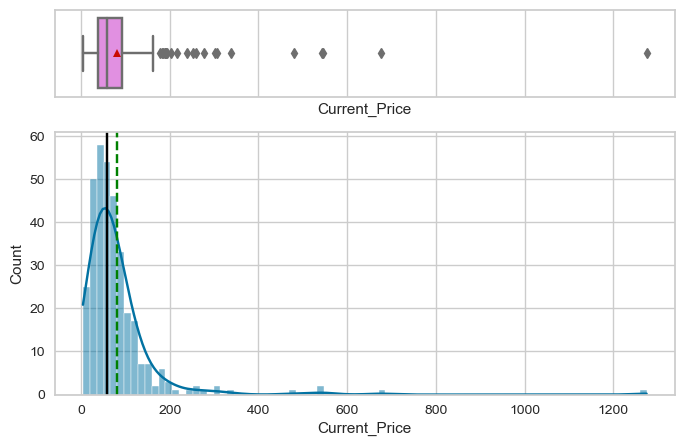

In [13]:
histogram_boxplot(df, 'Current_Price', kde = True)

* Current_price distribution is right-skewed, long right tail
* Mean current price is about 80 dollars

**`Price Change`**

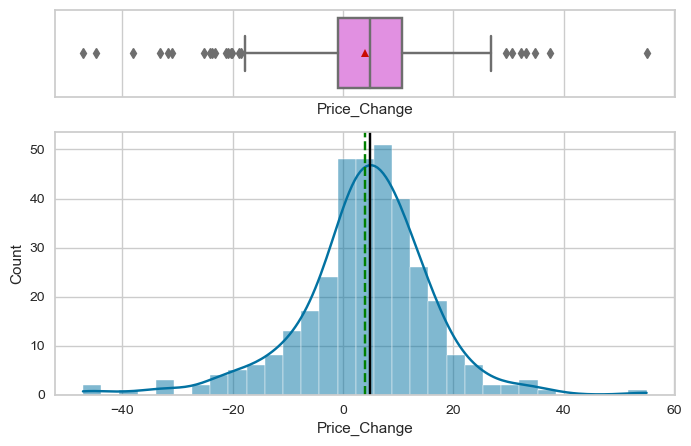

In [14]:
histogram_boxplot(df, 'Price_Change', kde = True)

* Price_change distribution is almost normal
* Mean and median price change are very close to each other

**`Volatility`**

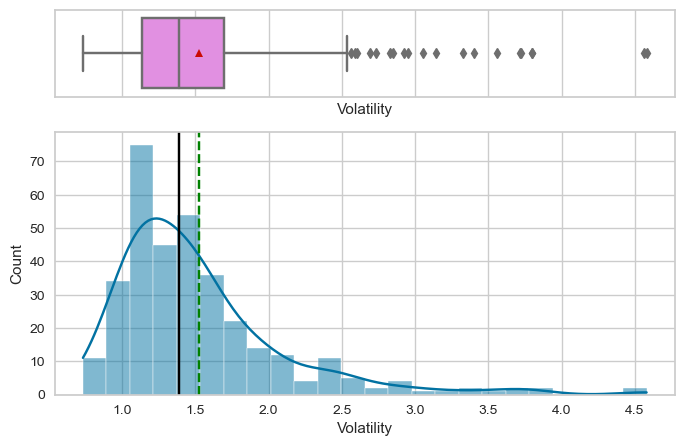

In [15]:
histogram_boxplot(df, 'Volatility', kde = True)

* Volatility distribution is right skewed

**`ROE`**

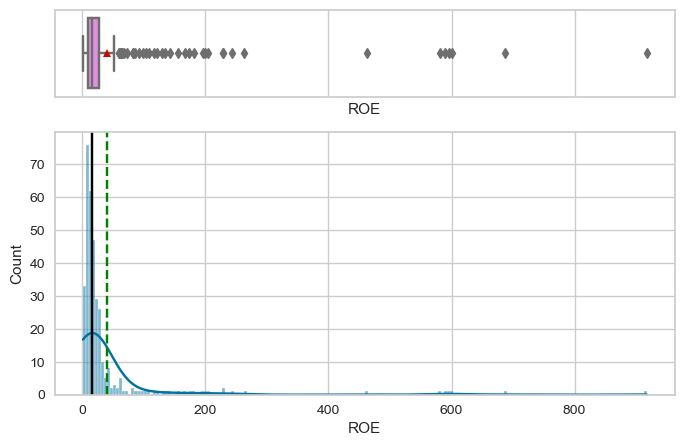

In [16]:
histogram_boxplot(df, 'ROE', kde = True)

* ROE distribution is heavily right skewed
* Most stocks have ROE under 100

**`Cash Ratio`**

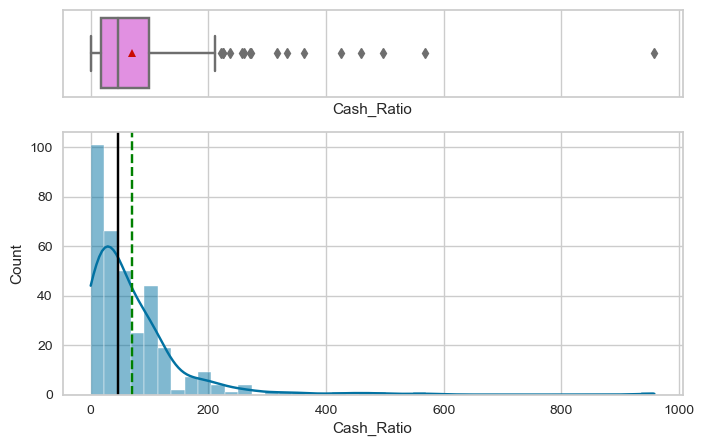

In [17]:
histogram_boxplot(df, 'Cash_Ratio', kde = True)

* Cash_ratio distribution is right-skewed, mean cash ratio is about 70

**`Net Cash Flow`**

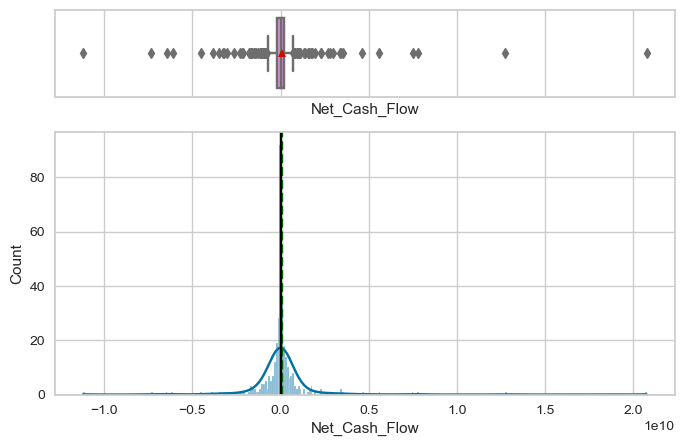

In [18]:
histogram_boxplot(df, 'Net_Cash_Flow', kde = True)

* Net cash flow distribution is normal, shows lot of lower and upper outliers

**`Net Income`**

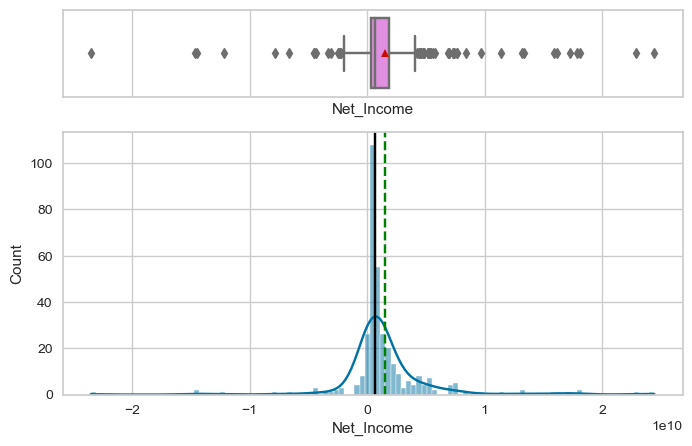

In [19]:
histogram_boxplot(df, 'Net_Income', kde = True)

* Net Income distribution is normal, there are outliers present

**`Earnings Per Share`**

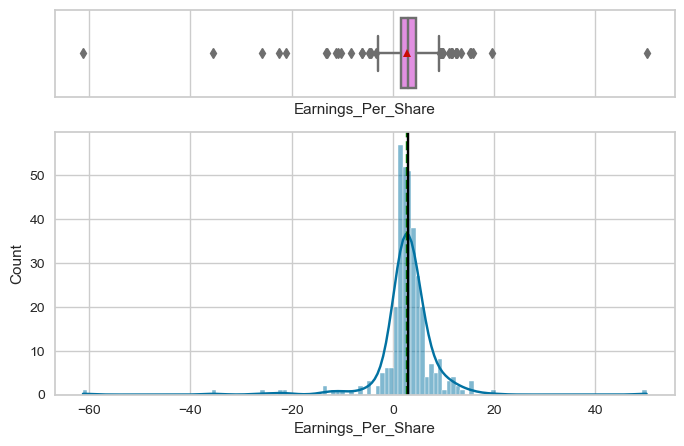

In [20]:
histogram_boxplot(df, 'Earnings_Per_Share', kde = True)

* Earnings per share distribution is almost normal, more outliers on lower end

**`Estimated Shares Outstanding`**

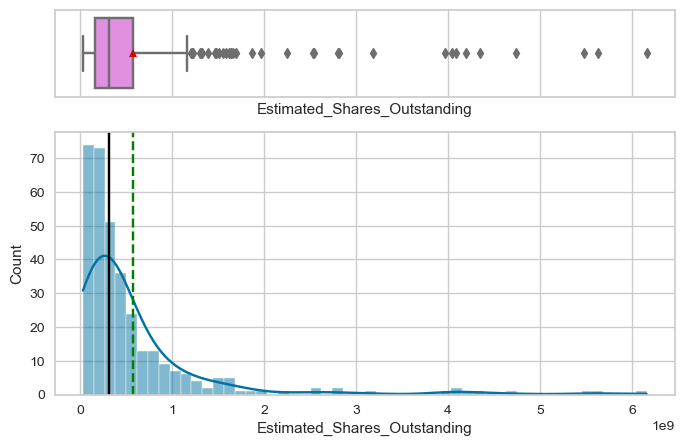

In [21]:
histogram_boxplot(df, 'Estimated_Shares_Outstanding', kde = True)

* Estimated shares outstanding distribution is right skewed, some companies have billions of shares

**`P/E Ratio`**

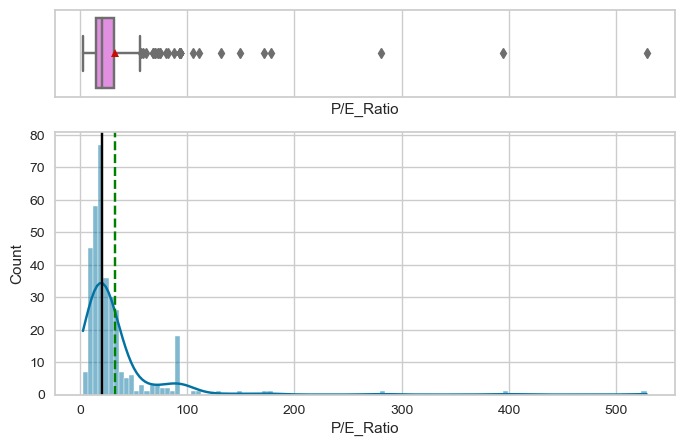

In [22]:
histogram_boxplot(df, 'P/E_Ratio', kde = True)

* P/E ratio distribution is right skewed
* Mean value around 30, median around 20

**`P/B Ratio`**

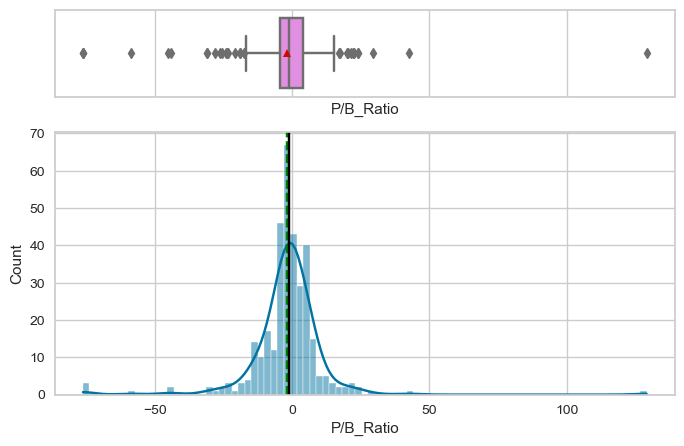

In [23]:
histogram_boxplot(df, 'P/B_Ratio', kde = True)

* P/B ratio distribution is somewhat normal, there are both lower and upper outliers

In [24]:
# function to create labeled barplots


def labeled_barplot(df, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(df[feature])  # length of the column
    count = df[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=df,
        x=feature,
        palette="Paired",
        order=df[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

**`GICS Sector`**

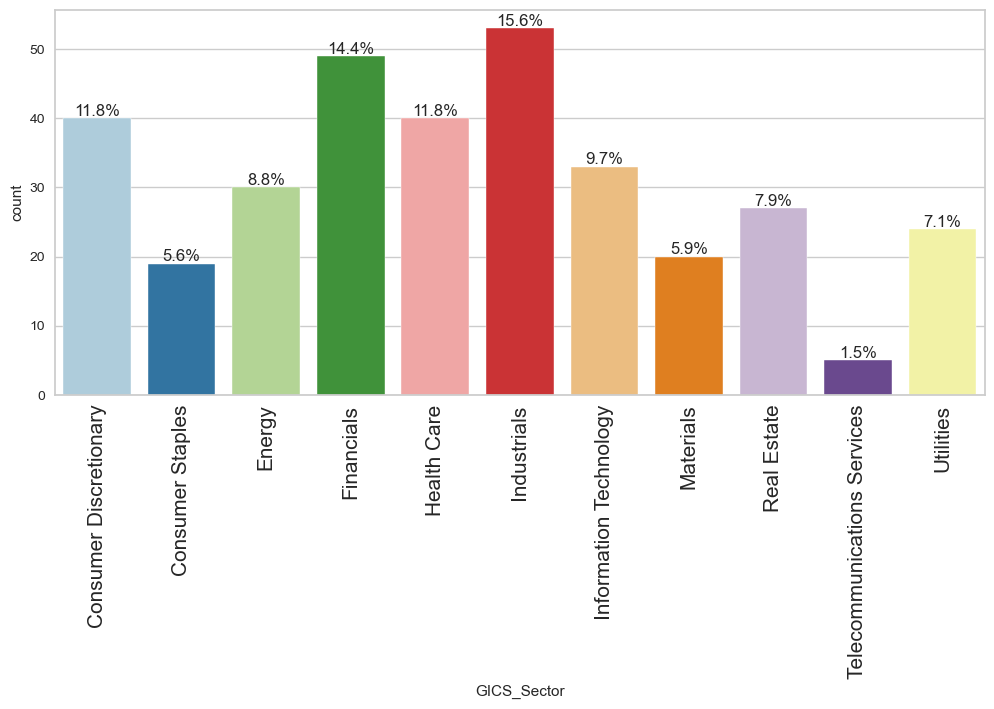

In [25]:
labeled_barplot(df, 'GICS_Sector', perc=True)

* Industrials sector contributes to 15% of 340 companies
* Financials,Industrials, Healthcare sectors together make up about 42% of companies
* Telecommunication Services, Consumer staples contribute 7%

**`GICS Sub Industry`**

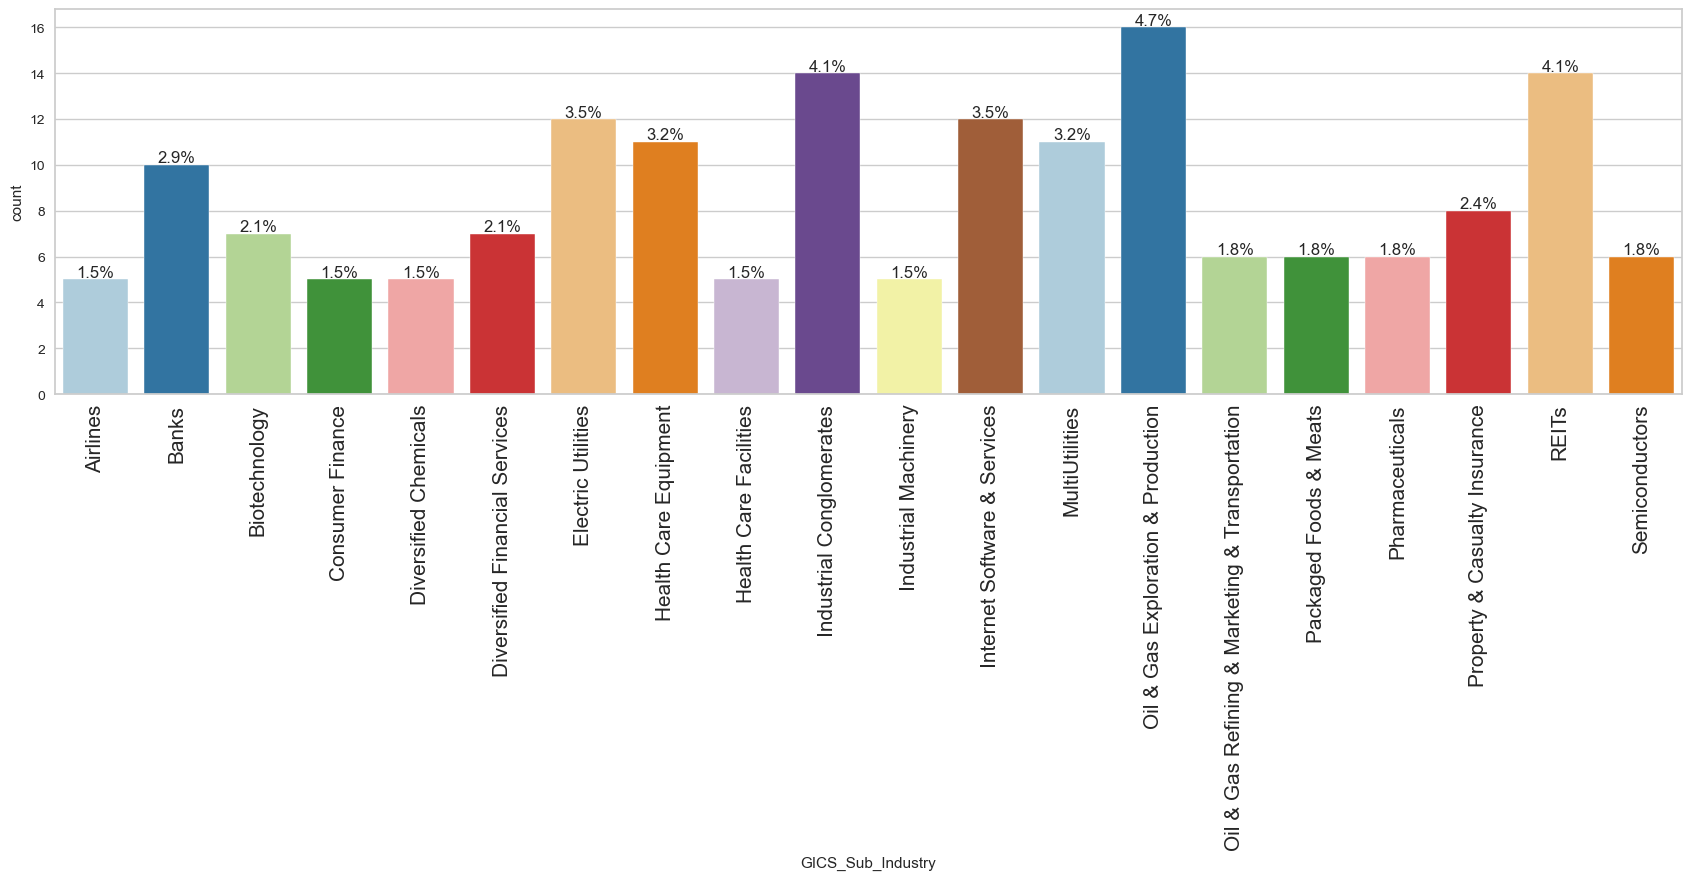

In [26]:
labeled_barplot(df, 'GICS_Sub_Industry', n=20, perc=True)

In [27]:
# GICS Sub Industry top 5
df['GICS_Sub_Industry'].value_counts()

Oil & Gas Exploration & Production                 16
REITs                                              14
Industrial Conglomerates                           14
Internet Software & Services                       12
Electric Utilities                                 12
MultiUtilities                                     11
Health Care Equipment                              11
Banks                                              10
Property & Casualty Insurance                       8
Diversified Financial Services                      7
Biotechnology                                       7
Pharmaceuticals                                     6
Semiconductors                                      6
Packaged Foods & Meats                              6
Oil & Gas Refining & Marketing & Transportation     6
Diversified Chemicals                               5
Consumer Finance                                    5
Industrial Machinery                                5
Health Care Facilities      

* Oil and Gas Refining is the most common sub industry, comprised of 16 companies, followed by Conglomerates, REITs, Internet Software and Services, Electric Utilities
* There are about 40 sub_industry stocks represented by just 1 company each

### Bivariate Analysis

In [28]:
## create a list of numeric columns in dataset
num_col = df.select_dtypes(include=np.number).columns.tolist()

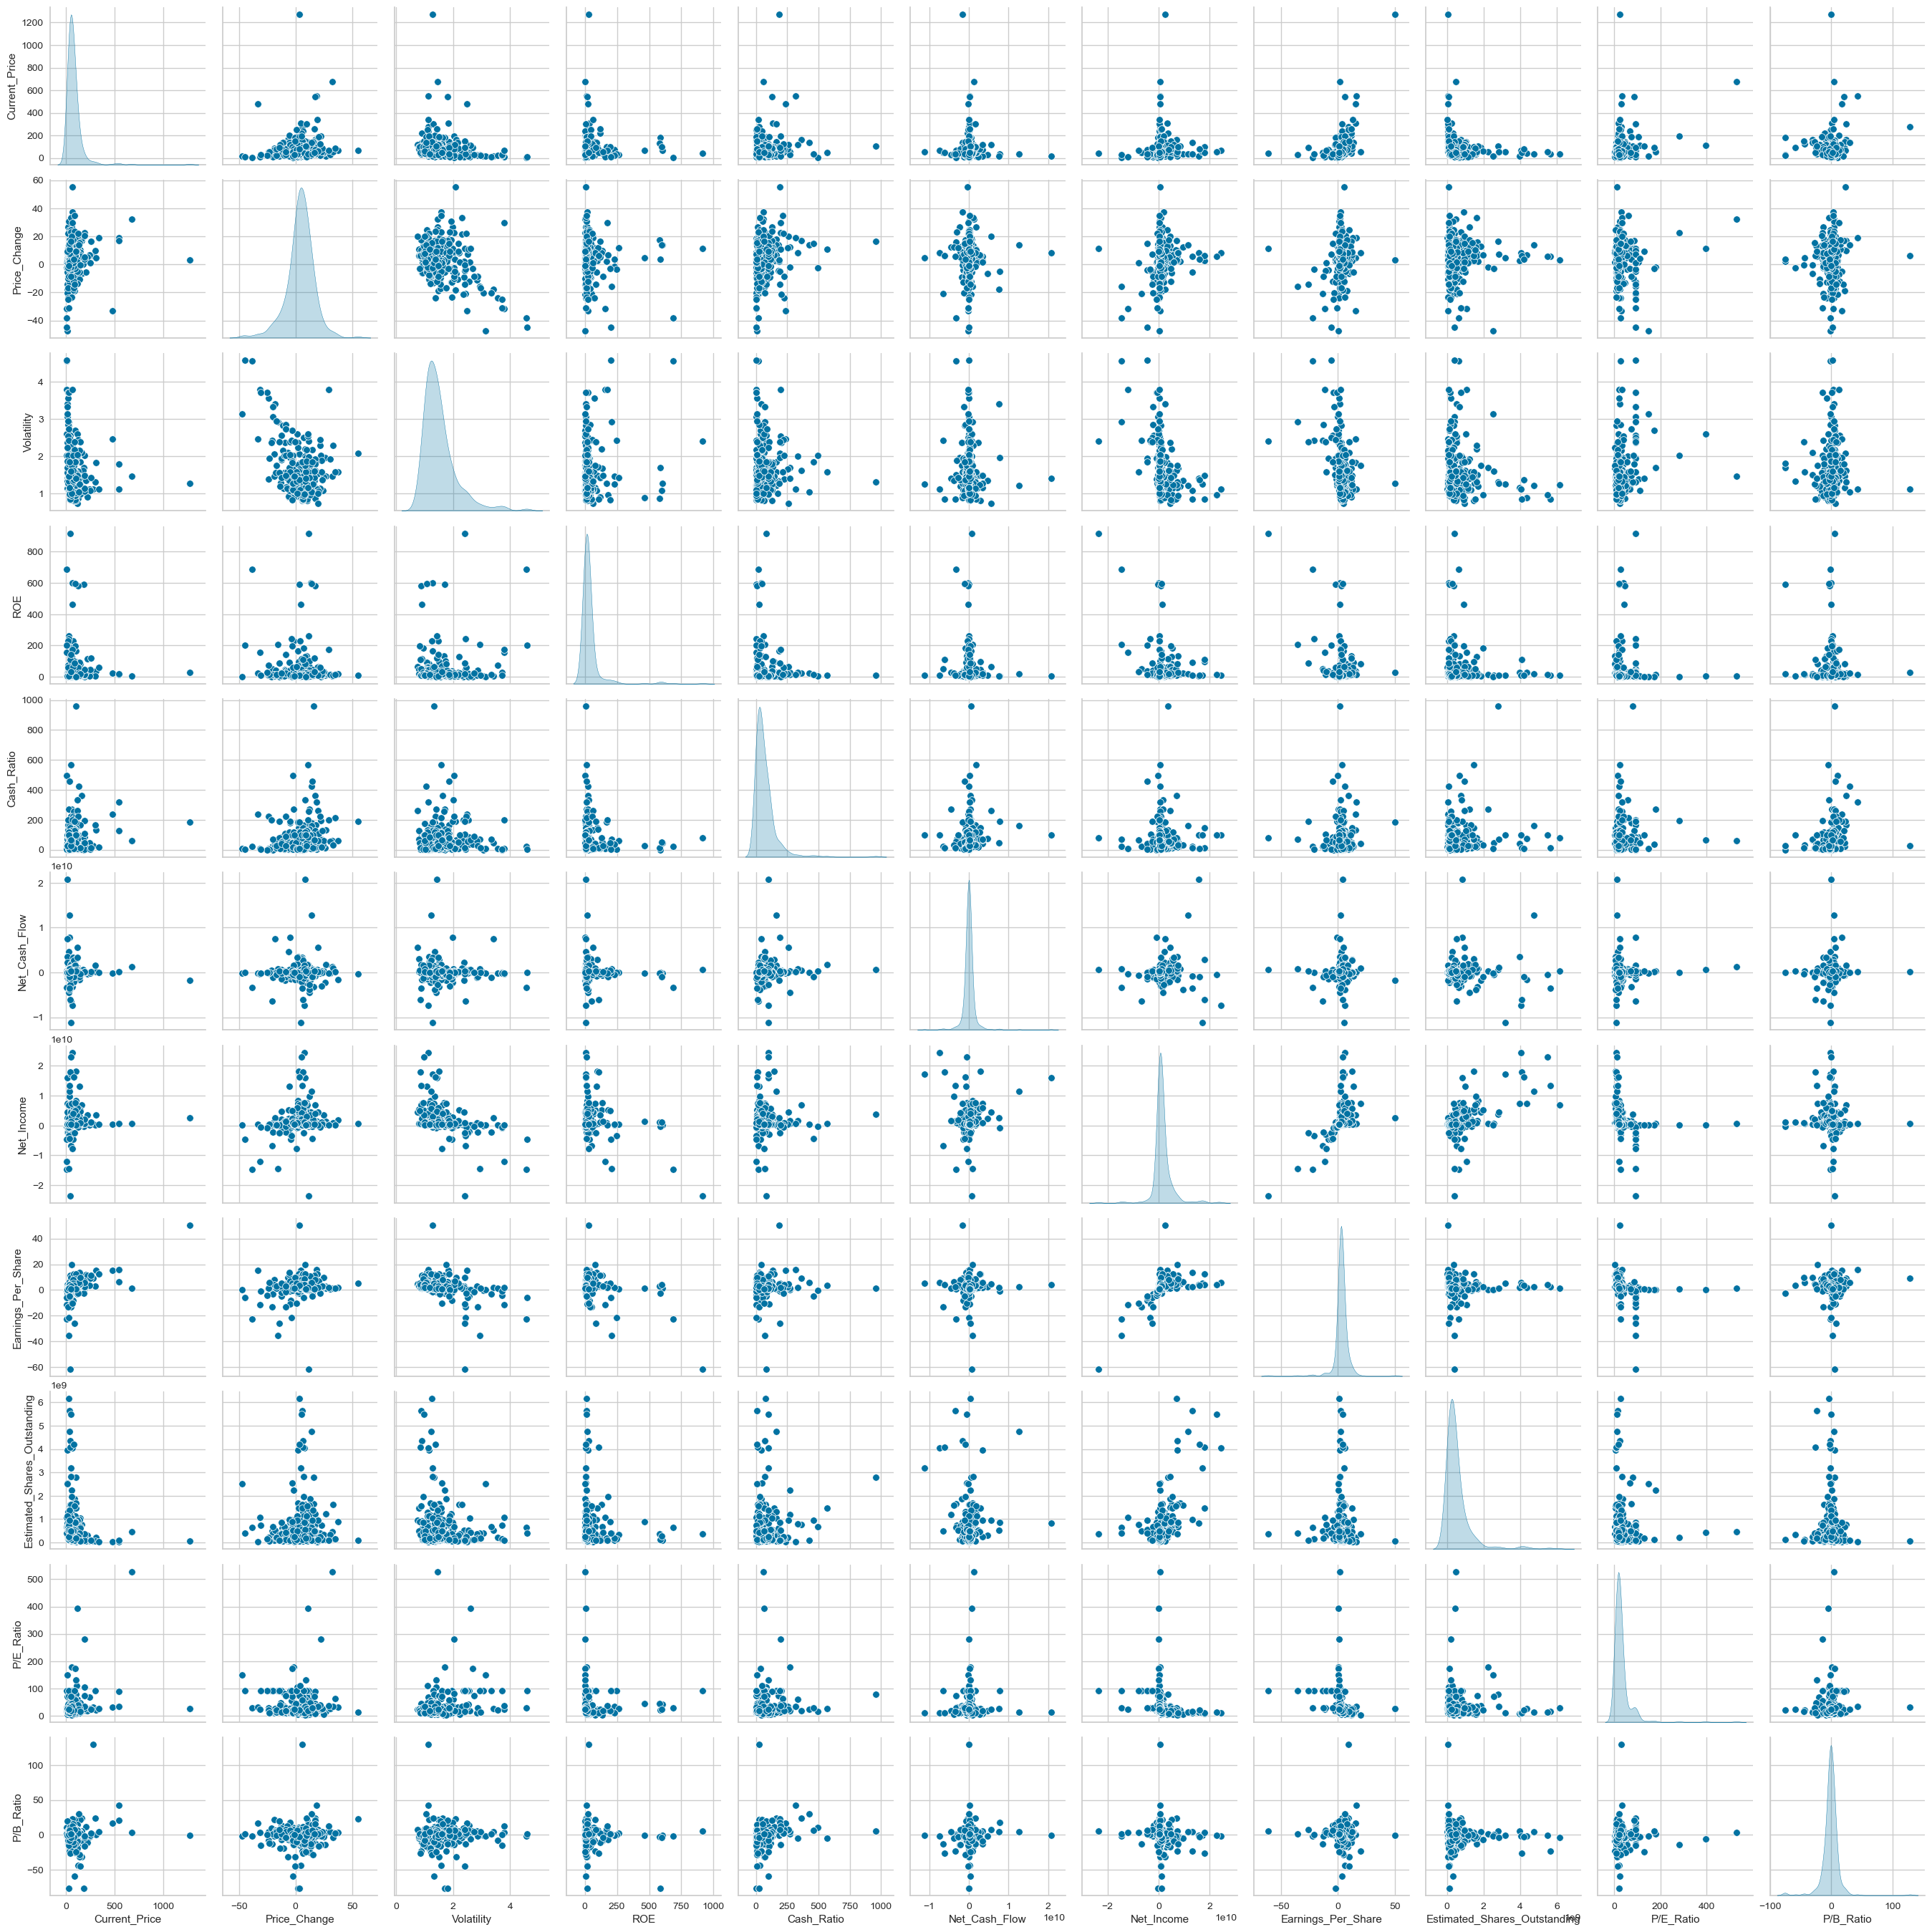

In [29]:
## pairplot to show correlation between numeric columns
sns.pairplot(data=df[num_col], diag_kind="kde")
plt.show()

#### Observations:

* Current stock price, volatility, ROE, cash ratio, P/E ratio, estimated outstanding shares attributes are right skewed
* Stock price change, net cash flow, net income, earnings per share, P/B ratio are normally distributed


## Questions:

#### 1) What does the distribution of stock prices look like?

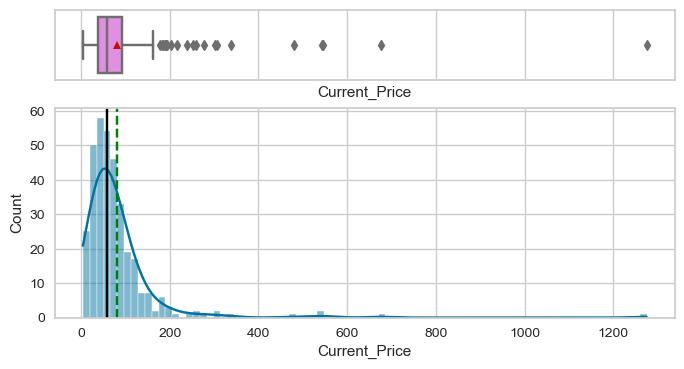

In [30]:
histogram_boxplot(df, "Current_Price", kde=True, figsize=(8, 4))


* Distribution of current stock price is right skewed
* There are upper outliers, mean stock price is around $80


#### 2) The stocks of which economic sector have seen maximum price increase on average?

In [31]:
df.groupby("GICS_Sector")["Price_Change"].mean()

GICS_Sector
Consumer Discretionary          5.846093
Consumer Staples                8.684750
Energy                        -10.228289
Financials                      3.865406
Health Care                     9.585652
Industrials                     2.833127
Information Technology          7.217476
Materials                       5.589738
Real Estate                     6.205548
Telecommunications Services     6.956980
Utilities                       0.803657
Name: Price_Change, dtype: float64

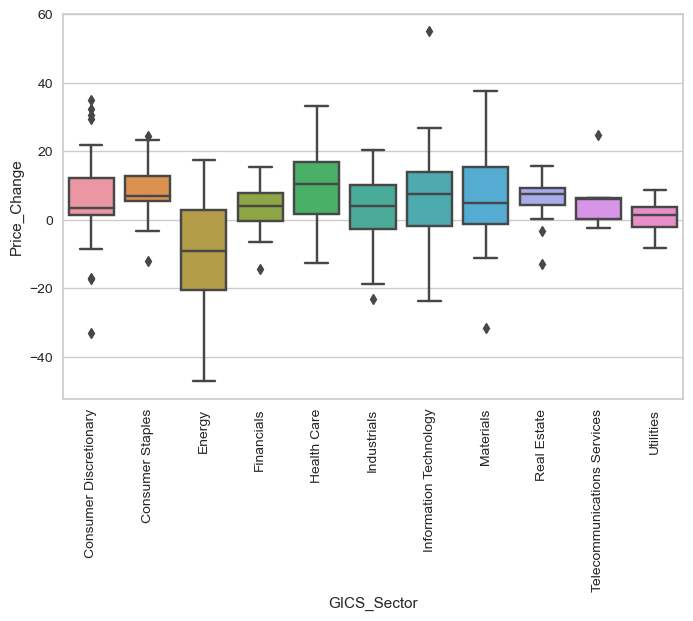

In [32]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="GICS_Sector", y="Price_Change")
plt.xticks(rotation=90)
plt.show()

** Healthcare sector stocks have seen maximum price increase **

#### 3) How are the different variables correlated with each other?

In [33]:
df.corr()

,Current_Price,Price_Change,Volatility,ROE,Cash_Ratio,Net_Cash_Flow,Net_Income,Earnings_Per_Share,Estimated_Shares_Outstanding,P/E_Ratio,P/B_Ratio
Current_Price,1.000000,0.134982,-0.124257,-0.000549,0.127816,-0.021961,0.036625,0.479604,-0.145306,0.260273,0.124634
Price_Change,0.134982,1.000000,-0.408281,-0.043310,0.168586,0.026746,0.179298,0.175401,0.033656,-0.002491,0.034329
Volatility,-0.124257,-0.408281,1.000000,0.162532,0.020605,-0.014172,-0.383433,-0.379309,-0.095704,0.263600,0.046528
ROE,-0.000549,-0.043310,0.162532,1.000000,-0.069122,-0.052205,-0.288524,-0.405291,-0.030288,0.023341,-0.063218
Cash_Ratio,0.127816,0.168586,0.020605,-0.069122,1.000000,0.113819,0.028589,0.024759,0.135869,0.089483,0.229672
Net_Cash_Flow,-0.021961,0.026746,-0.014172,-0.052205,0.113819,1.000000,0.044229,0.019348,-0.051392,0.026876,0.057039
Net_Income,0.036625,0.179298,-0.383433,-0.288524,0.028589,0.044229,1.000000,0.557752,0.589310,-0.224022,-0.061544
Earnings_Per_Share,0.479604,0.175401,-0.379309,-0.405291,0.024759,0.019348,0.557752,1.000000,-0.026906,-0.260660,0.014915
Estimated_Shares_Outstanding,-0.145306,0.033656,-0.095704,-0.030288,0.135869,-0.051392,0.589310,-0.026906,1.000000,-0.014551,-0.028155
P/E_Ratio,0.260273,-0.002491,0.263600,0.023341,0.089483,0.026876,-0.224022,-0.260660,-0.014551,1.000000,0.036422


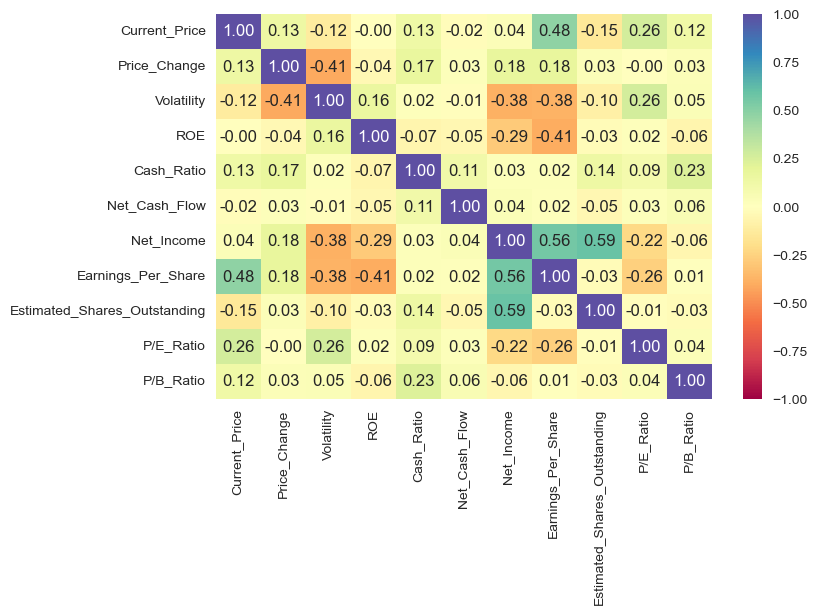

In [34]:
# correlation check
plt.figure(figsize=(8, 5))
sns.heatmap(
    df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

#### Observations:

* Current stock price and earnings per share are positively correlated, which is obvious
* Net income is positively correlated with earnings per share and number of outstanding shares
* This is understandable. As net income grows, shareholders earn more and more stocks get sold
* Price_change and volatility are negatively correlated


#### 4) Cash ratio provides a measure of a company's ability to cover its short-term obligations using only cash and cash equivalents. How does average cash ratio vary across economic sectors?

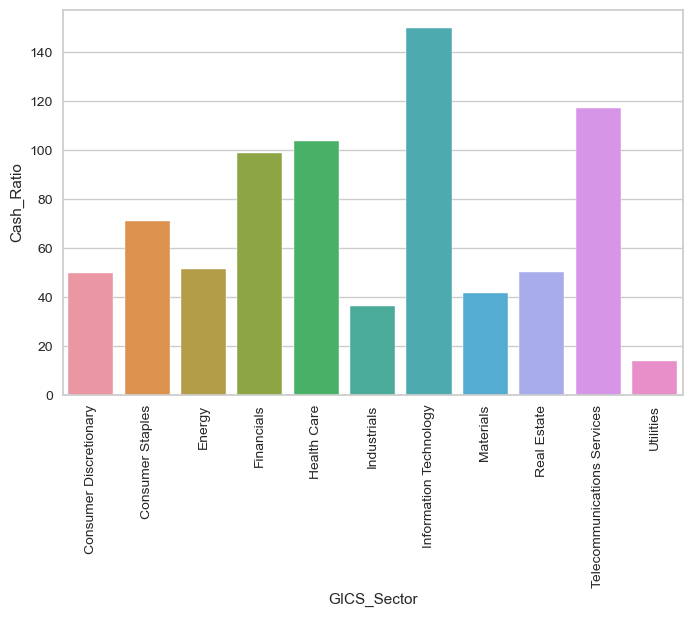

In [35]:
plt.figure(figsize=(8,5))
sns.barplot(data=df, x= 'GICS_Sector', y='Cash_Ratio', ci=False)
plt.xticks(rotation=90)
plt.show()

#### Observations:

* IT, Telecommunications and Healthcare sectors have the highest average cash ratio
* Utilities, Industrials and Materials sectors have the lowest average cash ratio


#### 5) P/E ratios can help determine the relative value of a company's shares as they signify the amount of money an investor is willing to invest in a single share of a company per dollar of its earnings. How does P/E ratio vary across economic sectors ?

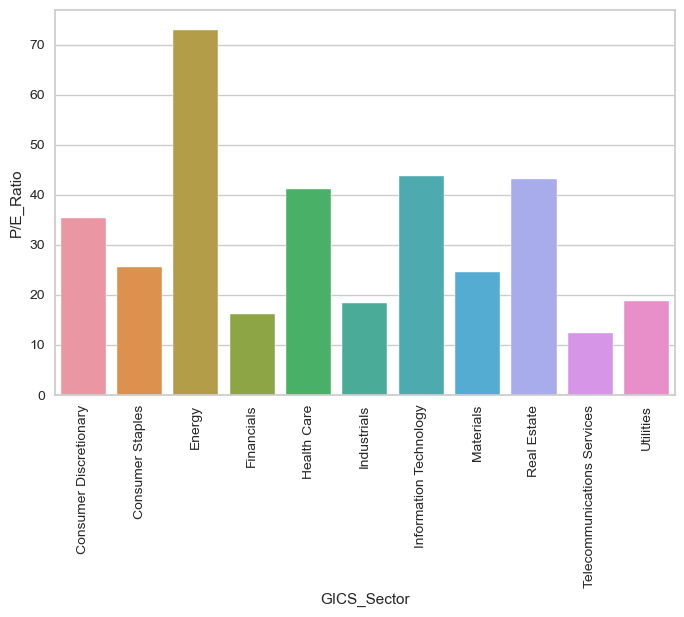

In [36]:
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='GICS_Sector', y='P/E_Ratio', ci=False)
plt.xticks(rotation=90)
plt.show()

* Energy sector companies have highest P/E ratio

### Additional analysis

#### Volatility across Economic Sectors

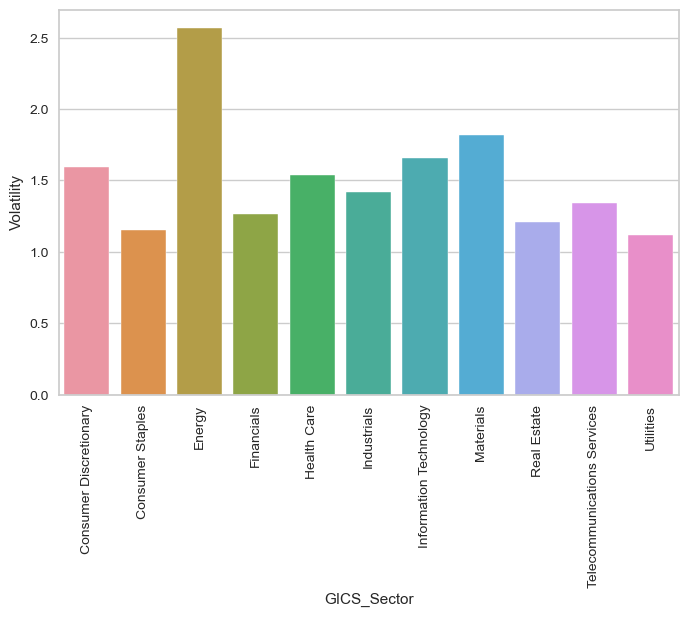

In [37]:
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='GICS_Sector', y='Volatility', ci=False)
plt.xticks(rotation=90)
plt.show()

* Energy, Materials, Information Technology, Healthcare sectors have high volatility
* Utilities, consumer staples and Real estate show low volatility, these are safer investment sectors in that sense

#### Net income across Economic Sectors

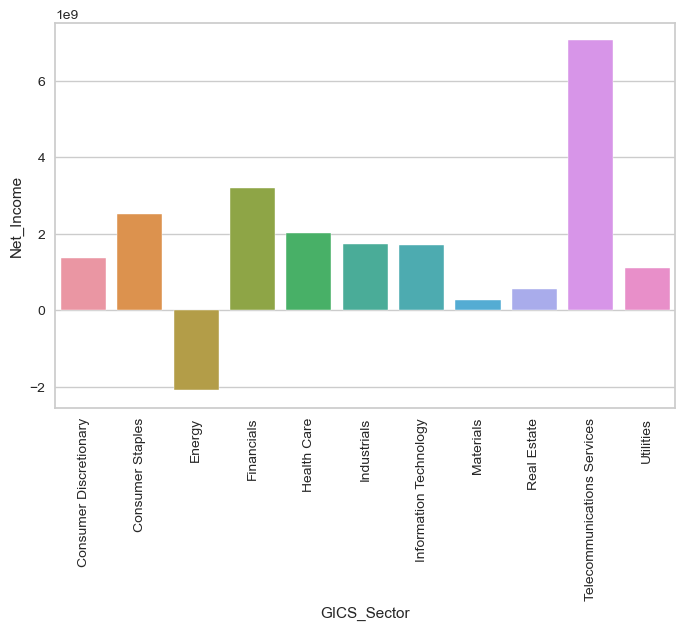

In [38]:
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='GICS_Sector', y='Net_Income', ci=False)
plt.xticks(rotation=90)
plt.show()

* Telecommunications has the highest net income
* Energy sector shows negative income, indicating losses in the previous quarter

#### Outstanding shares across Economic Sectors

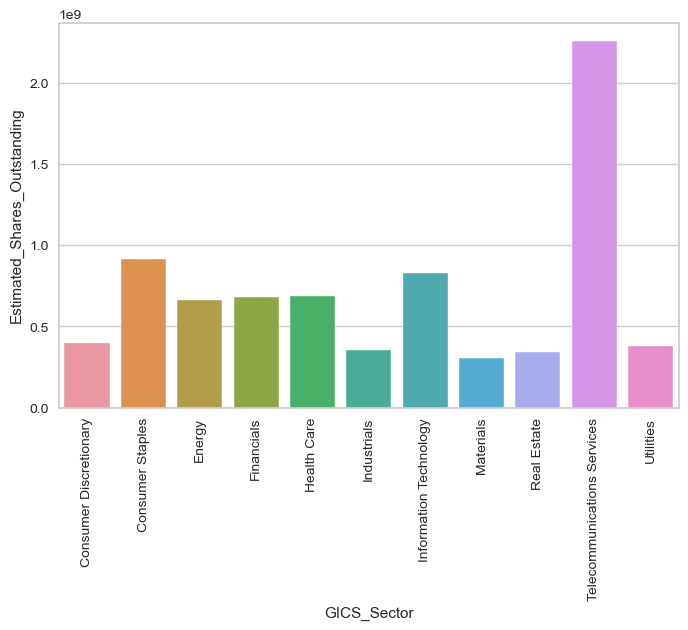

In [39]:
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='GICS_Sector', y='Estimated_Shares_Outstanding', ci=False)
plt.xticks(rotation=90)
plt.show()

* Telecommunications sector has highest outstanding shares
* Utilities and Consumer Discretionary sectors have the least outstanding shares

## Data Preprocessing

* There are no duplicate or missing values as observed in EDA above

### Outlier Check

- Let's plot boxplots of all numerical columns to check for outliers.

In [40]:
# create list of numeric columns
num_col = df.select_dtypes(include=np.number).columns.tolist()
num_col

['Current_Price',
 'Price_Change',
 'Volatility',
 'ROE',
 'Cash_Ratio',
 'Net_Cash_Flow',
 'Net_Income',
 'Earnings_Per_Share',
 'Estimated_Shares_Outstanding',
 'P/E_Ratio',
 'P/B_Ratio']

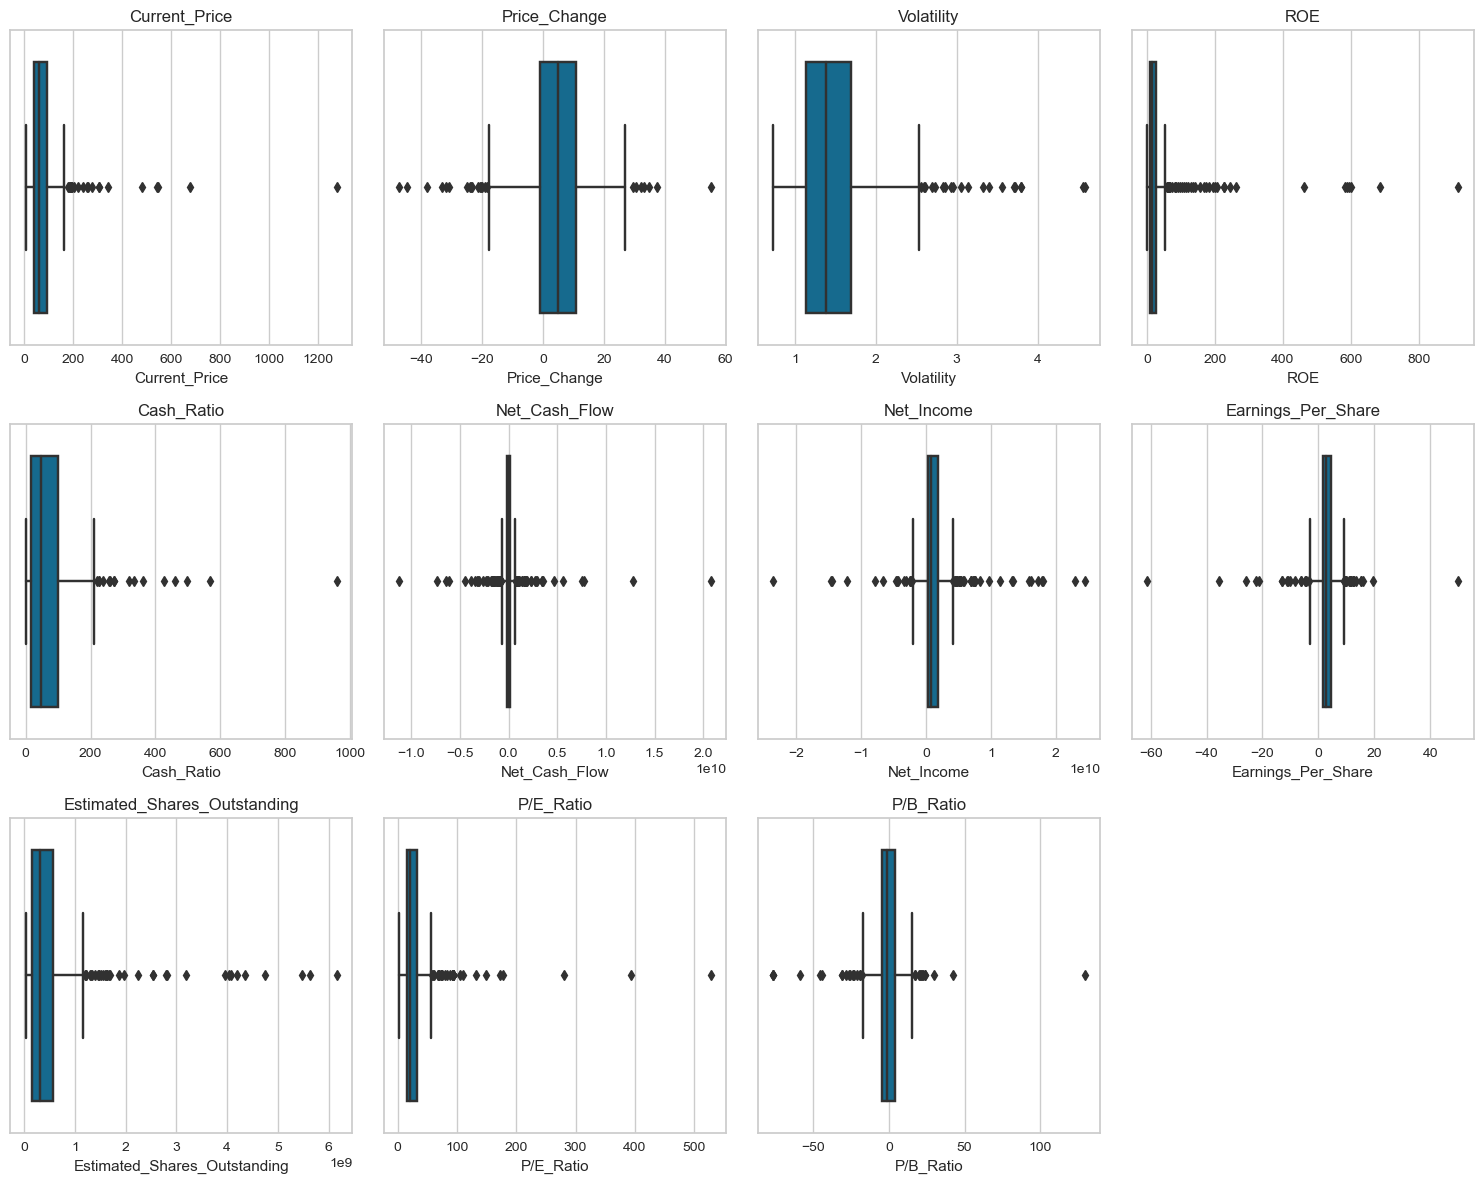

In [41]:
plt.figure(figsize=(15, 12))

for i, variable in enumerate(num_col):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

#### Treating Outliers

* There are outliers in all numeric columns
* Euclidean distance is sensitive to outliers
* For sake of normalizing distributions and to avoid clustering algorithms to be impacted by outliers, they can be treated using capping and clipping methods
* All values smaller than lower whisker will be replaced with lower whisker
* All values greater than upper whisker will be replaced with upper whisker

In [42]:
## function to treat outliers

def treat_outliers(df, col):
    """
    treats outliers in a variable
    col: str, name of the numerical variable
    df: dataframe
    col: name of the column
    """
    Q1 = df[col].quantile(0.25)  # 25th quantile
    Q3 = df[col].quantile(0.75)  # 75th quantile
    IQR = Q3 - Q1
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

    # all values smaller than Lower_Whisker will be assigned value of Lower_Whisker
    # all values greater than Upper_Whisker will be assigned value of Upper_Whisker
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)

    return df


def treat_outliers_apply(df, col_list):
    """
    treat outlier in all numerical variables
    col_list: list of numerical variables
    df: data frame
    """
    for c in col_list:
        df = treat_outliers(df, c)

    return df


In [43]:
df = treat_outliers_apply(df, num_col)  # function to treat outliers

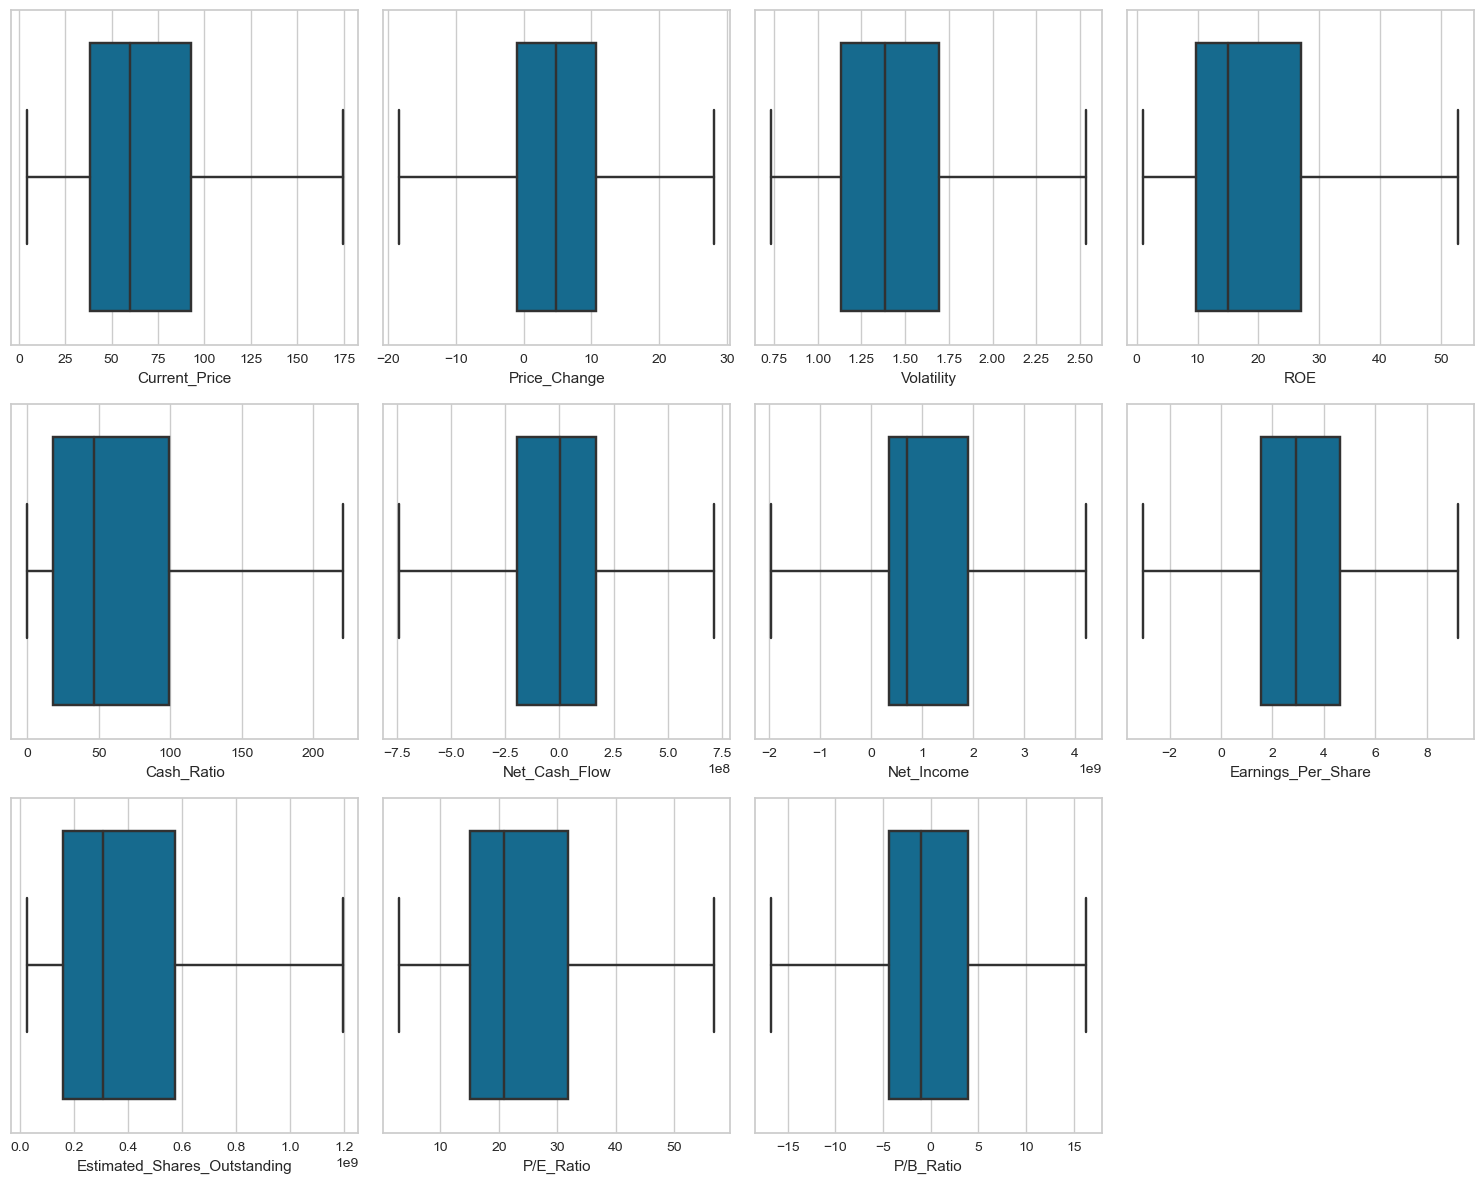

In [44]:
# let's check boxplots after outlier treatment

plt.figure(figsize=(15, 12))

for i, variable in enumerate(num_col):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(df[variable], whis=1.5)
    plt.tight_layout()

plt.show()

* Outliers treatment complete
* lets continue scaling data

### Scaling

In [45]:
# scaling data before clustering
scaler = StandardScaler()
subset = df[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

In [46]:
# creating a dataframe of scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

In [47]:
subset_scaled_df.head()

,Current_Price,Price_Change,Volatility,ROE,Cash_Ratio,Net_Cash_Flow,Net_Income,Earnings_Per_Share,Estimated_Shares_Outstanding,P/E_Ratio,P/B_Ratio
0,-0.650712,0.549287,0.448212,2.116831,-0.207311,-1.433763,1.977138,2.114902,0.645054,-1.493768,-0.997339
1,-0.257962,0.387909,1.568844,2.116831,0.238584,0.133007,1.977138,0.017981,2.124799,-0.462139,-0.992836
2,-0.591183,0.675734,-0.459081,0.031532,0.067086,1.722229,1.977138,-0.054640,2.124799,-0.703554,0.108970
3,0.548932,0.935802,-0.274700,-0.753522,2.005016,-0.565079,-0.371735,-0.635605,0.171420,2.138684,0.714710
4,-0.349115,-0.600175,0.478969,-0.426416,2.699583,0.764786,-0.327678,-0.964127,2.124799,2.138684,0.300691


## Applying K-means Clustering

### Plot Elbow Curve

In [48]:
## creating a copy of scaled dataset

k_means_df = subset_scaled_df.copy()

Number of Clusters: 1 	Average Distortion: 3.1482665386211908
Number of Clusters: 2 	Average Distortion: 2.9507542400143842
Number of Clusters: 3 	Average Distortion: 2.759761533270845
Number of Clusters: 4 	Average Distortion: 2.63153843620545
Number of Clusters: 5 	Average Distortion: 2.5345886566890665
Number of Clusters: 6 	Average Distortion: 2.4703313338147543
Number of Clusters: 7 	Average Distortion: 2.3892036349104346
Number of Clusters: 8 	Average Distortion: 2.3415378767145505
Number of Clusters: 9 	Average Distortion: 2.302109092619317
Number of Clusters: 10 	Average Distortion: 2.2377809582576833
Number of Clusters: 11 	Average Distortion: 2.204551626221652
Number of Clusters: 12 	Average Distortion: 2.183120889408329
Number of Clusters: 13 	Average Distortion: 2.136519876101571
Number of Clusters: 14 	Average Distortion: 2.1093177250276294


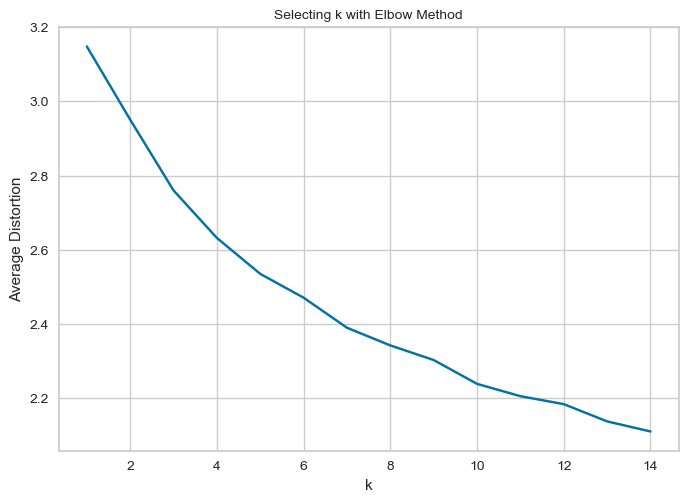

In [49]:
clusters = range(1, 15)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(subset_scaled_df)
    prediction = model.predict(k_means_df)
    distortion = (
        sum(np.min(cdist(k_means_df, model.cluster_centers_, "euclidean"), axis=1))
        / k_means_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with Elbow Method", fontsize=10)
plt.show()

#### Observations:

* There are clear nicks on curve at 3,5,7
* k=4 or 5 can be considered based on elbow curve
* Lets check silhouette score


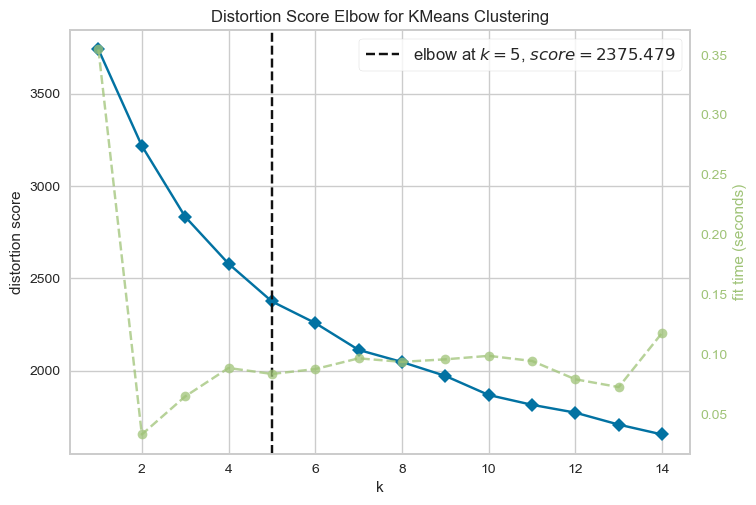

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [50]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(1, 15), timings=True)
visualizer.fit(k_means_df)  # fit the data to the visualizer
visualizer.show()  # finalize and render figure

### Check silhouette scores

For n_clusters = 2, the silhouette score is 0.14040363305436732)
For n_clusters = 3, the silhouette score is 0.1818864171381463)
For n_clusters = 4, the silhouette score is 0.1653160289647168)
For n_clusters = 5, the silhouette score is 0.14591373480130365)
For n_clusters = 6, the silhouette score is 0.14123009384579105)
For n_clusters = 7, the silhouette score is 0.1371811289782077)
For n_clusters = 8, the silhouette score is 0.13111986503005277)
For n_clusters = 9, the silhouette score is 0.12839314434358204)
For n_clusters = 10, the silhouette score is 0.1393666960963218)
For n_clusters = 11, the silhouette score is 0.135393326699983)
For n_clusters = 12, the silhouette score is 0.13543944176814168)
For n_clusters = 13, the silhouette score is 0.13808929034629017)
For n_clusters = 14, the silhouette score is 0.12467396300203645)


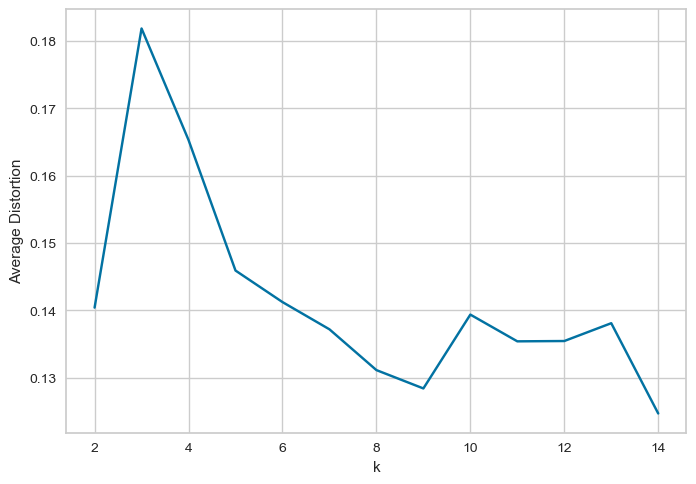

In [51]:
sil_score = []
cluster_list = range(2, 15)
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    preds = clusterer.fit_predict((subset_scaled_df))
    score = silhouette_score(k_means_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.plot(cluster_list, sil_score)
plt.show()

#### ** K = 3 has highest silhouette score followed by K = 4  **

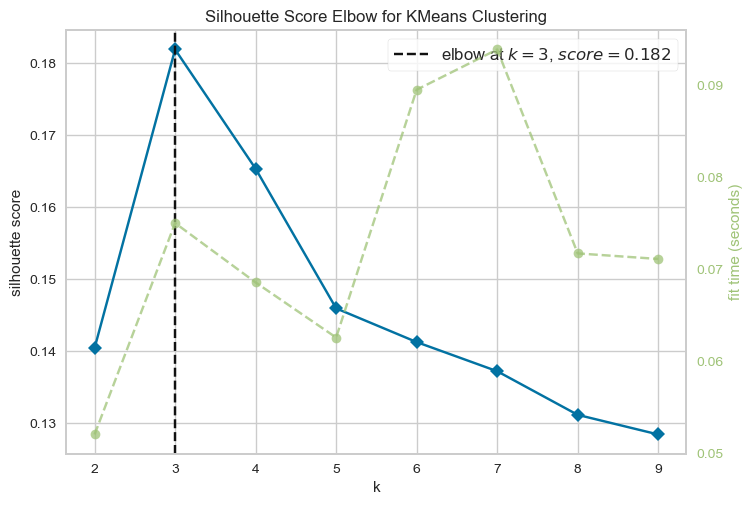

Wall time: 905 ms


<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [52]:
%%time

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric="silhouette", timings= True)
visualizer.fit(k_means_df)  # fit data to visualizer
visualizer.show()  # finalize and render figure

####   Observations:

* k = 3 has highest silhoutte score 0.182, followed by k=4(silhouette score 0.165) and k=5(silhouette score 0.145)
* Lets continue finding optimal K using Silhoutte coefficients method


### Finding Optimal number of clusters using silhouette score

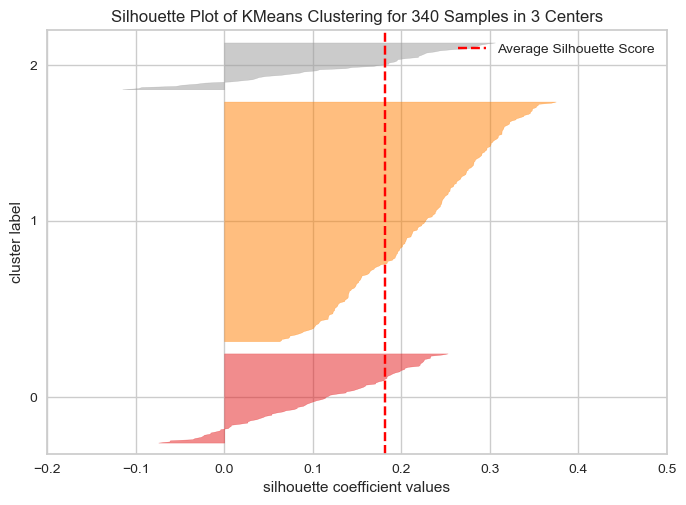

Wall time: 287 ms


<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 340 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [53]:
%%time

# finding optimal no. of clusters with silhouette coefficients

visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))  ## silhouette score for k = 3
visualizer.fit(k_means_df)
visualizer.show()

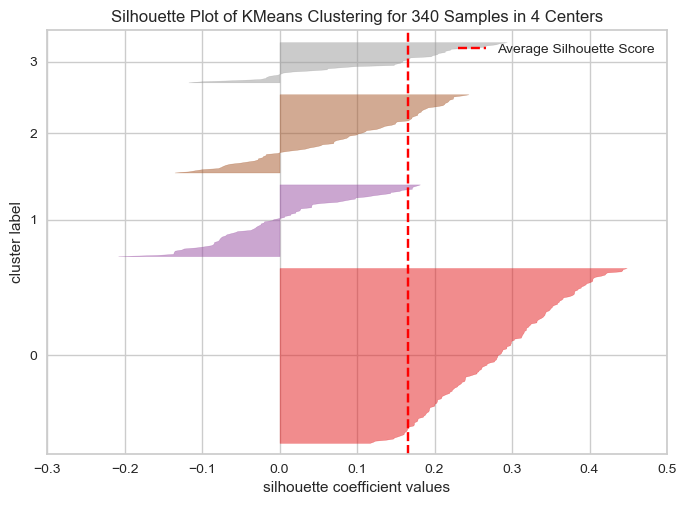

Wall time: 292 ms


<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 340 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [54]:
%%time
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))  ## silhouette score for k = 4
visualizer.fit(k_means_df)
visualizer.show()

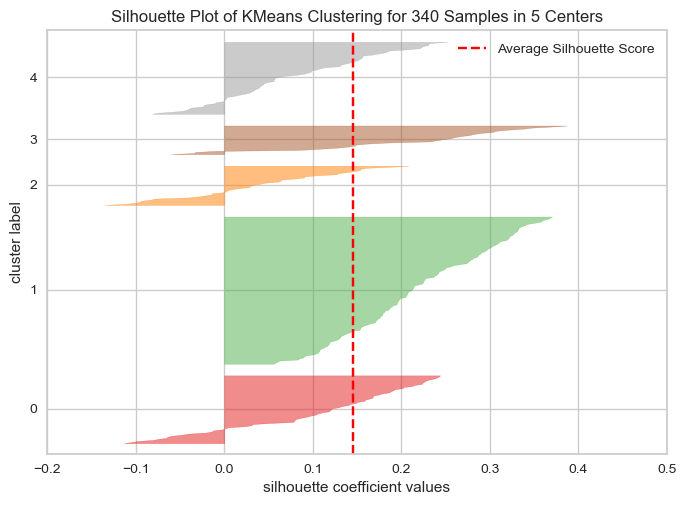

Wall time: 299 ms


<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 340 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [55]:
%%time
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))  ## silhouette score for k = 5
visualizer.fit(k_means_df)
visualizer.show()

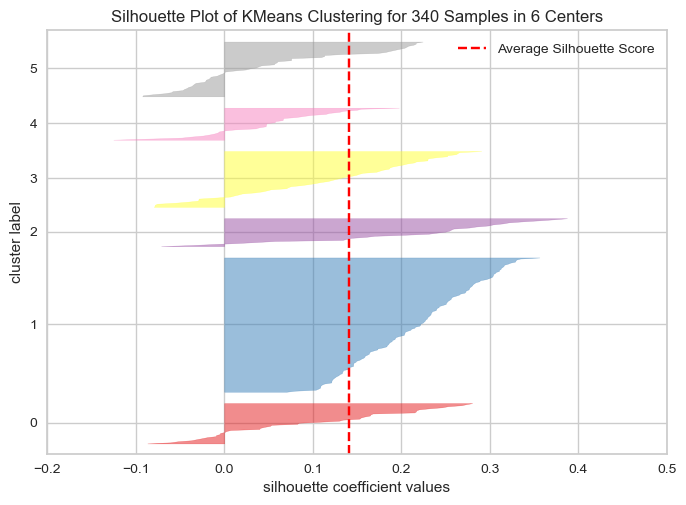

Wall time: 425 ms


<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 340 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [56]:
%%time
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state=1))  ## silhouette scores for k = 6
visualizer.fit(k_means_df)
visualizer.show()

#### Observations and choosing final K:

* k=3 plot has a thick cluster 1 with a lot of datapoints
* k=4 plot has one big cluster and clusters 1,2,3 with comparable number of datapoints
* k=5 has 1 big cluster and 4 smaller clusters of comparable size
* k=6 also shows 1 big cluster and 5 comparable clusters
* k=4 is chosen as final cluster as it has a high silhouette score and clusters have good variability


### Creating Model with k=4

In [57]:
# final K-means model
kmeans = KMeans(n_clusters=4, random_state=1)  ## code to choose number of clusters
kmeans.fit(k_means_df)

KMeans(n_clusters=4, random_state=1)

In [58]:
# creating a copy of original data
df1 = df.copy()

# adding kmeans cluster labels to original and scaled dataframes
k_means_df["KM_segments"] = kmeans.labels_
df1["KM_segments"] = kmeans.labels_



### Cluster Profiling with k =4

In [59]:
km_cluster_profile = df1.groupby("KM_segments").mean()  ## code to groupby cluster labels

In [60]:
km_cluster_profile["count_in_each_segment"] = (
    df1.groupby("KM_segments")["Security"].count().values  ## code to groupby cluster labels
)

In [61]:
km_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Current_Price,Price_Change,Volatility,ROE,Cash_Ratio,Net_Cash_Flow,Net_Income,Earnings_Per_Share,Estimated_Shares_Outstanding,P/E_Ratio,P/B_Ratio,count_in_each_segment
KM_segments,,,,,,,,,,,,
0,55.244803,4.138915,1.369178,16.636574,45.922840,-27048595.679012,672680086.419753,2.503056,284332040.515880,23.326393,-2.770381,162
1,133.912166,8.445776,1.448696,25.636194,87.559701,19138819.029851,1224493856.343284,5.764272,226466364.473433,27.582452,0.606231,67
2,63.016032,7.307222,1.328582,23.280822,72.479452,45780250.000000,3360419313.356164,4.255702,935007689.001884,18.587531,-1.490857,73
3,36.617074,-7.671510,2.324252,22.733553,75.078947,-47577213.815789,-766637134.868421,-1.290691,517244885.279671,44.959149,2.684753,38


In [62]:
## code to print companies in each cluster

for cl in df1["GICS_Sector"].unique():
    print("In cluster {}, the following companies are present:".format(cl))
    print(df1[df1["GICS_Sector"] == cl]["Security"].unique())
    print()

In cluster Industrials, the following companies are present:
['American Airlines Group', 'Alaska Air Group Inc', 'Allegion', 'AMETEK Inc', 'Arconic Inc', ..., 'United Parcel Service', 'United Technologies', 'Verisk Analytics', 'Waste Management Inc.', 'Xylem Inc.']
Length: 53
Categories (340, object): ['3M Company', 'AFLAC Inc', 'AMETEK Inc', 'AT&T Inc', ..., 'Zimmer Biomet Holdings', 'Zions Bancorp', 'Zoetis', 'eBay Inc.']

In cluster Health Care, the following companies are present:
['AbbVie', 'Abbott Laboratories', 'Alexion Pharmaceuticals', 'Amgen Inc', 'Anthem Inc.', ..., 'Vertex Pharmaceuticals Inc', 'Waters Corporation', 'Dentsply Sirona', 'Zimmer Biomet Holdings', 'Zoetis']
Length: 40
Categories (340, object): ['3M Company', 'AFLAC Inc', 'AMETEK Inc', 'AT&T Inc', ..., 'Zimmer Biomet Holdings', 'Zions Bancorp', 'Zoetis', 'eBay Inc.']

In cluster Information Technology, the following companies are present:
['Adobe Systems Inc', 'Analog Devices, Inc.', 'Alliance Data Systems', 'Ak

In [63]:
df1.groupby(["KM_segments", "GICS_Sector"])['Security'].count()

KM_segments  GICS_Sector                
0            Consumer Discretionary         25
             Consumer Staples                8
             Energy                          0
             Financials                     24
             Health Care                    12
             Industrials                    30
             Information Technology         11
             Materials                      10
             Real Estate                    20
             Telecommunications Services     1
             Utilities                      21
1            Consumer Discretionary         11
             Consumer Staples                3
             Energy                          1
             Financials                      8
             Health Care                    18
             Industrials                     9
             Information Technology          6
             Materials                       5
             Real Estate                     6
             Teleco

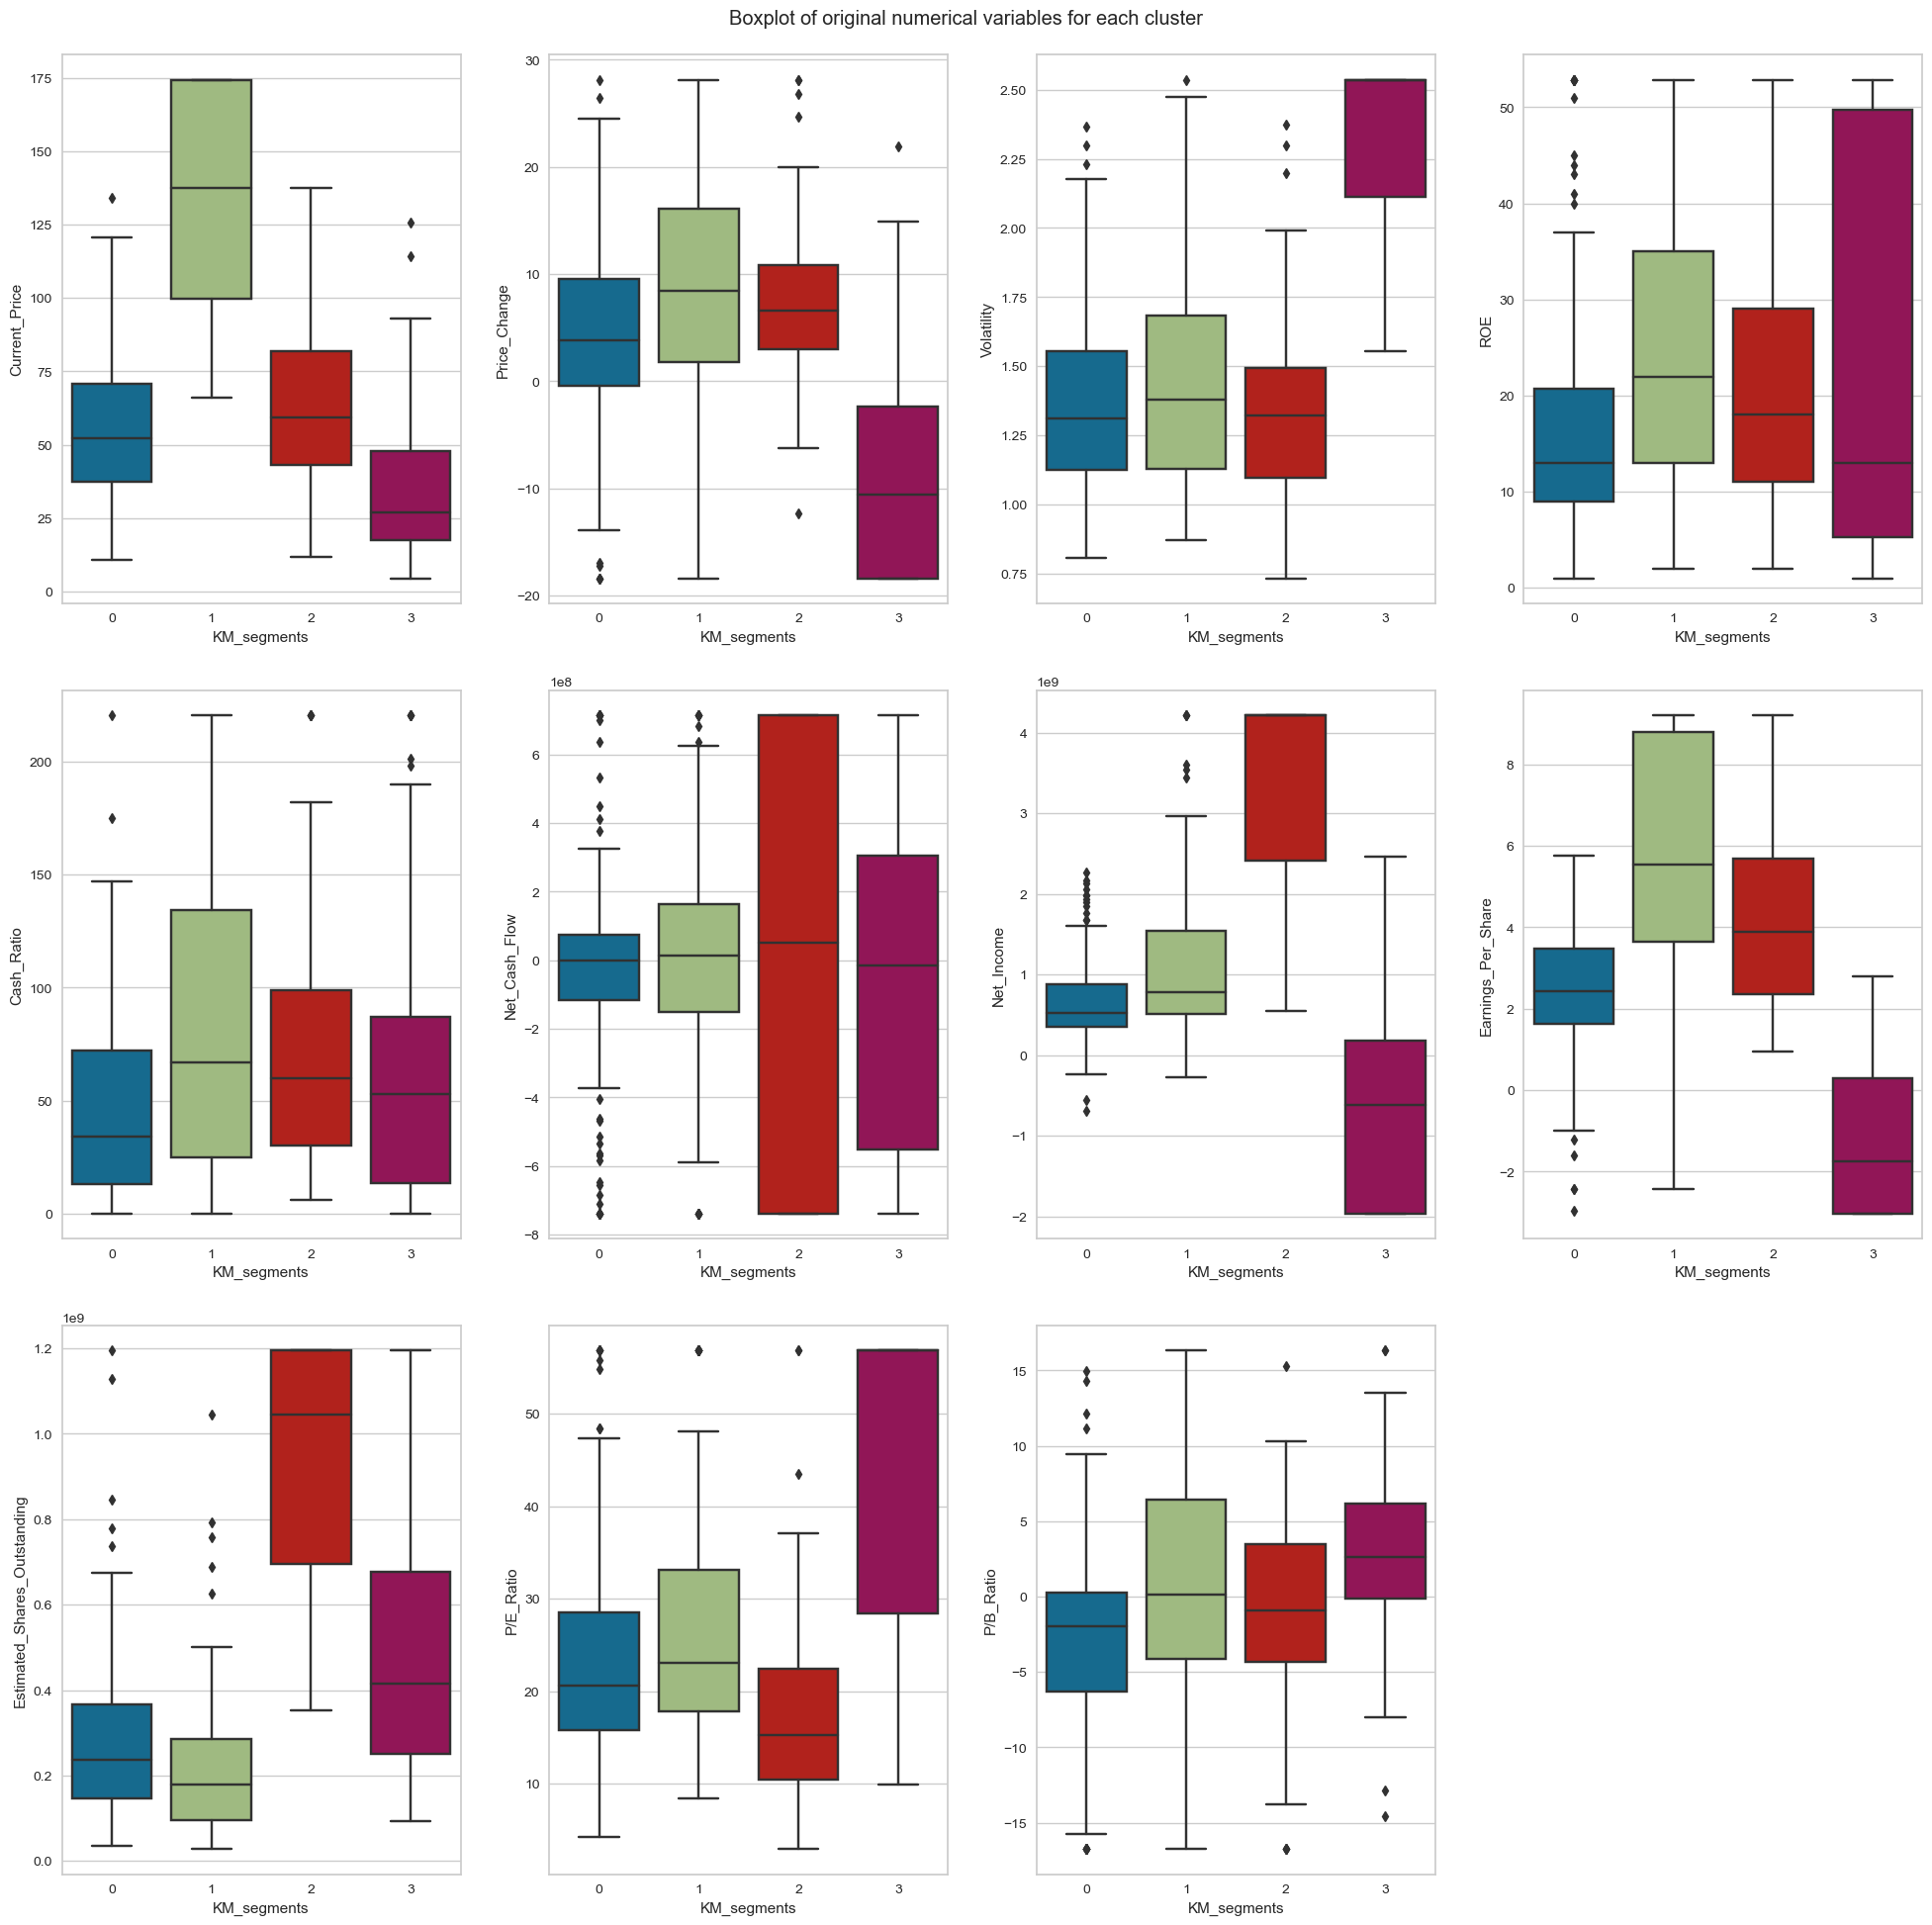

In [64]:
plt.figure(figsize=(20, 20))
plt.suptitle("Boxplot of original numerical variables for each cluster")

# selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()

for i, variable in enumerate(num_col):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data=df1, x="KM_segments", y=variable)

plt.tight_layout(pad=2.0)

### Insights from k-means clustering

**Cluster 0** (162 companies, mainly comprising Consumer Discretionary,Industrials,Financials sectors)

* Stocks have moderate price and price change, medium volatility, low ROE, low cash ratio, low net cash flow, moderate net income, low/medium earnings per share, low estimated outstanding shares, moderate P/E ratio

**Cluster 1** (67 companies mainly comprising Healthcare and Consumer Discretionary sectors)

* Stocks have high price, high change in price, medium volatility, high ROE, high cash ratio, moderate net_cash_flow and net_income, high earnings per share, low estimated outstanding shares, moderate P/E ratio
** Out of all 4 clusters, this cluster has highest stock price, price change, ROE, cash ratio and earnings per share

**Cluster 2** (73 companies mainly comprising Financials, Industrials and Information Technology)

* Stocks have moderate price, moderate price change, medium volatility, moderate ROE, medium cash ratio, high net_cash_flow, high net income, moderate earnings per share, high oustanding shares, low P/E ratio
** Out of all 4 clusters, this cluster has highest net cash flow, net income and estimated outstanding shares

**Cluster 3** (38 companies mainly comprising Energy sector)

* Stocks have low price, low price change, high volatility, medium ROE, moderate cash ratio, low cash flow, low net income, low earnings per share, moderate oustanding shares, high P/E ratio
** This cluster has highest volatility, P/E ratio, P/B ratio



## Applying Hierarchical Clustering

### Computing Cophenetic Correlation

In [65]:
hc_df = subset_scaled_df.copy()

In [66]:
%%time
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(hc_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(hc_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm
            
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print('*'*100)
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Cophenetic correlation for Euclidean distance and single linkage is 0.6932108674136777.
Cophenetic correlation for Euclidean distance and complete linkage is 0.6147798823663769.
Cophenetic correlation for Euclidean distance and average linkage is 0.7325610568988987.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.6496438783746494.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7214024727237498.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.36805931247944257.
Cophenetic correlation for Chebyshev distance and average linkage is 0.7011385715318806.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.5032471223561586.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.6176064847170996.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.3854304450443971.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.641587600792573.
Cophenetic co

**Highest cophenetic correlation obtained with Euclidean distance and average linkage 

**Let's explore different linkage methods with Euclidean distance only.**

In [67]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(hc_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(hc_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm
        
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print('*'*100)
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Cophenetic correlation for single linkage is 0.6932108674136777.
Cophenetic correlation for complete linkage is 0.6147798823663769.
Cophenetic correlation for average linkage is 0.7325610568988987.
Cophenetic correlation for centroid linkage is 0.7294329307928586.
Cophenetic correlation for ward linkage is 0.5753306117577637.
Cophenetic correlation for weighted linkage is 0.6496438783746494.
****************************************************************************************************
Highest cophenetic correlation is 0.7325610568988987, which is obtained with average linkage.


**Cophenetic correlation is maximum with Euclidean distance and average linkage**

**Let's view dendrograms for different linkage methods with Euclidean distance.**

### Checking Dendrograms

Wall time: 2.09 s


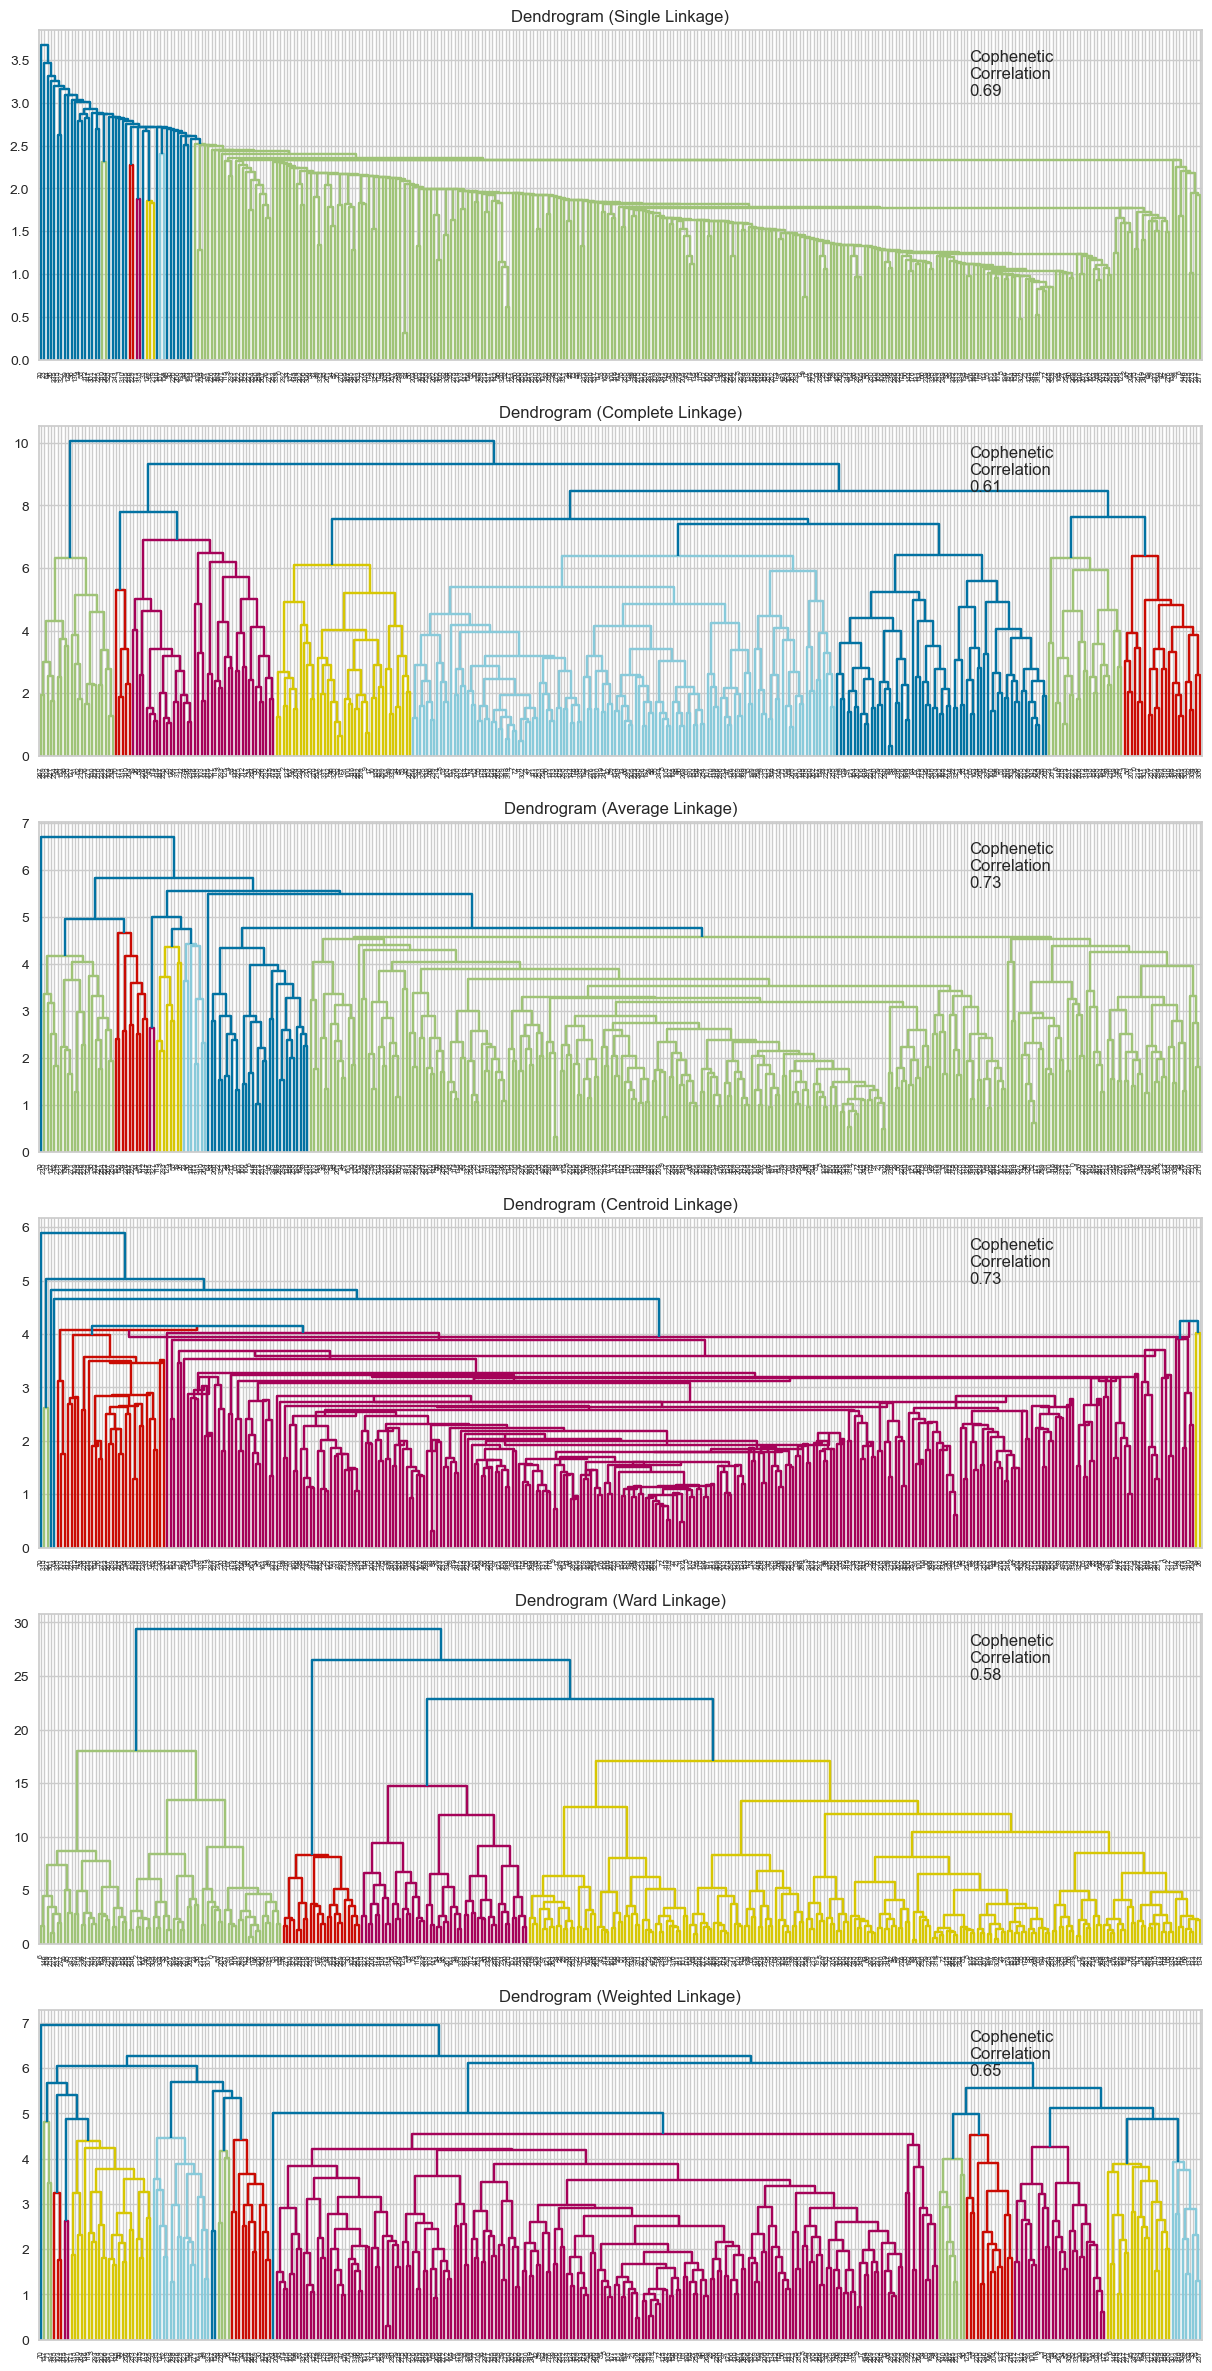

In [68]:
%%time

# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(hc_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(hc_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

In [69]:
# create and print a dataframe to compare cophenetic correlations for different linkage methods
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc = df_cc.sort_values(by="Cophenetic Coefficient")
df_cc

,Linkage,Cophenetic Coefficient
4,ward,0.575331
1,complete,0.614780
5,weighted,0.649644
0,single,0.693211
3,centroid,0.729433
2,average,0.732561


#### Observations:

* Average and centroid linkages have highest cophenetic coefficients respectively
* Average linkage dendrogram shows 5 distinct clusters
* Centroid linkage dendrogram is not as distinct as average linkage
* 5 clusters and average linkage are chosen for hierarchical clustering model based on dendrogram

### Creating model using sklearn

In [70]:
## code to define hierarchical clustering model with k=5 and average linkage
HCmodel = AgglomerativeClustering(n_clusters=5, affinity="euclidean", linkage="average") 
HCmodel.fit(hc_df)

AgglomerativeClustering(linkage='average', n_clusters=5)

In [71]:
# creating a copy of original data
df2 = df.copy()

# adding hierarchical cluster labels to original and scaled dataframes
hc_df["HC_segments"] = HCmodel.labels_
df2["HC_segments"] = HCmodel.labels_

### Cluster Profiling

In [72]:
hc_cluster_profile = df2.groupby("HC_segments").mean()  ## code to groupby cluster labels

In [73]:
hc_cluster_profile["count_in_each_segment"] = (
    df2.groupby("HC_segments")["Security"].count().values  ## code to groupby cluster labels
)

In [74]:
hc_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Current_Price,Price_Change,Volatility,ROE,Cash_Ratio,Net_Cash_Flow,Net_Income,Earnings_Per_Share,Estimated_Shares_Outstanding,P/E_Ratio,P/B_Ratio,count_in_each_segment
HC_segments,,,,,,,,,,,,
0,124.283384,17.649246,1.702071,19.338235,191.352941,217965698.529412,922378654.411765,3.054338,426077063.146176,42.799223,7.215829,17
1,70.175620,5.081576,1.369438,20.025862,55.189655,-21331598.706897,1435189369.396552,3.592599,438277246.543207,22.157904,-2.083928,290
2,35.513226,-9.052249,2.384953,24.677419,63.596774,34989008.064516,-803106294.354839,-1.523871,472889826.396855,47.957287,2.164800,31
3,174.367503,-18.391948,2.474002,22.000000,220.500000,-171460000.000000,475602000.000000,9.213750,31085098.040000,31.362745,16.320749,1
4,174.367503,3.598507,1.697942,52.875000,0.000000,2000000.000000,-271000000.000000,-2.430000,111522633.700000,20.819876,-16.755740,1


####  Observations:

* There are two clusters with just 1 company each
* There are two clusters with 17 and 31 companies each
* There is 1 cluster with 290 companies
* There is not enough variability in clusters 
**Lets use Ward linkage and 4 clusters as seen from dendrogram

In [75]:
## code to define the hierarchical clustering model
HCmodel = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="ward") 
HCmodel.fit(hc_df)

AgglomerativeClustering(n_clusters=4)

In [76]:
# creating a copy of the original data
df3 = df.copy()

# adding hierarchical cluster labels to the original and scaled dataframes
hc_df["HC_segments"] = HCmodel.labels_
df3["HC_segments"] = HCmodel.labels_

In [77]:
hc_cluster_profile = df3.groupby("HC_segments").mean()  ## code to groupby cluster labels

In [78]:
hc_cluster_profile["count_in_each_segment"] = (
    df3.groupby("HC_segments")["Security"].count().values
)

In [79]:
hc_cluster_profile.style.highlight_max(color="lightgreen", axis=0)


,Current_Price,Price_Change,Volatility,ROE,Cash_Ratio,Net_Cash_Flow,Net_Income,Earnings_Per_Share,Estimated_Shares_Outstanding,P/E_Ratio,P/B_Ratio,count_in_each_segment
HC_segments,,,,,,,,,,,,
0,64.314990,4.696713,1.421029,17.052995,47.748848,-25290543.202765,825666157.834101,2.832903,341278877.484170,24.018099,-2.698772,217
1,97.821720,9.169564,1.692473,19.890625,184.968750,256099937.500000,773959722.656250,2.923672,385288418.313281,36.583707,7.948064,32
2,89.249184,6.236216,1.273505,28.163603,61.360294,-16619750.000000,3447947779.411765,5.832408,762668149.056838,17.019267,-1.464228,68
3,32.947827,-11.234540,2.393770,31.478261,43.347826,-136632809.782609,-1356654576.086957,-2.242609,473814086.308804,50.100914,0.689859,23


#### Observations:

**Clusters are distinct with good variability using ward linkage**

**4 clusters using Ward linkage will be used as final model

In [80]:
# let's see names of companies in each cluster
for cl in df3["HC_segments"].unique():
    print("In cluster {}, the following companies are present:".format(cl))
    print(df3[df3["HC_segments"] == cl]["Security"].unique())
    print()


In cluster 2, the following companies are present:
['American Airlines Group', 'AbbVie', 'Abbott Laboratories', 'Alliance Data Systems', 'American International Group, Inc.', ..., 'United Technologies', 'Valero Energy', 'Verizon Communications', 'Wells Fargo', 'Exxon Mobil Corp.']
Length: 68
Categories (340, object): ['3M Company', 'AFLAC Inc', 'AMETEK Inc', 'AT&T Inc', ..., 'Zimmer Biomet Holdings', 'Zions Bancorp', 'Zoetis', 'eBay Inc.']

In cluster 1, the following companies are present:
['Adobe Systems Inc', 'Analog Devices, Inc.', 'Akamai Technologies Inc', 'Alexion Pharmaceuticals', 'Amgen Inc', ..., 'TripAdvisor', 'Verisign Inc.', 'Vertex Pharmaceuticals Inc', 'Waters Corporation', 'Wynn Resorts Ltd']
Length: 32
Categories (340, object): ['3M Company', 'AFLAC Inc', 'AMETEK Inc', 'AT&T Inc', ..., 'Zimmer Biomet Holdings', 'Zions Bancorp', 'Zoetis', 'eBay Inc.']

In cluster 0, the following companies are present:
['Archer-Daniels-Midland Co', 'Ameren Corp', 'American Electric Powe

In [81]:
df3.groupby(["HC_segments", "GICS_Sector"])['Security'].count()

HC_segments  GICS_Sector                
0            Consumer Discretionary         30
             Consumer Staples               12
             Energy                          2
             Financials                     35
             Health Care                    21
             Industrials                    36
             Information Technology         17
             Materials                      15
             Real Estate                    25
             Telecommunications Services     1
             Utilities                      23
1            Consumer Discretionary          4
             Consumer Staples                1
             Energy                          2
             Financials                      1
             Health Care                     9
             Industrials                     1
             Information Technology         10
             Materials                       2
             Real Estate                     1
             Teleco

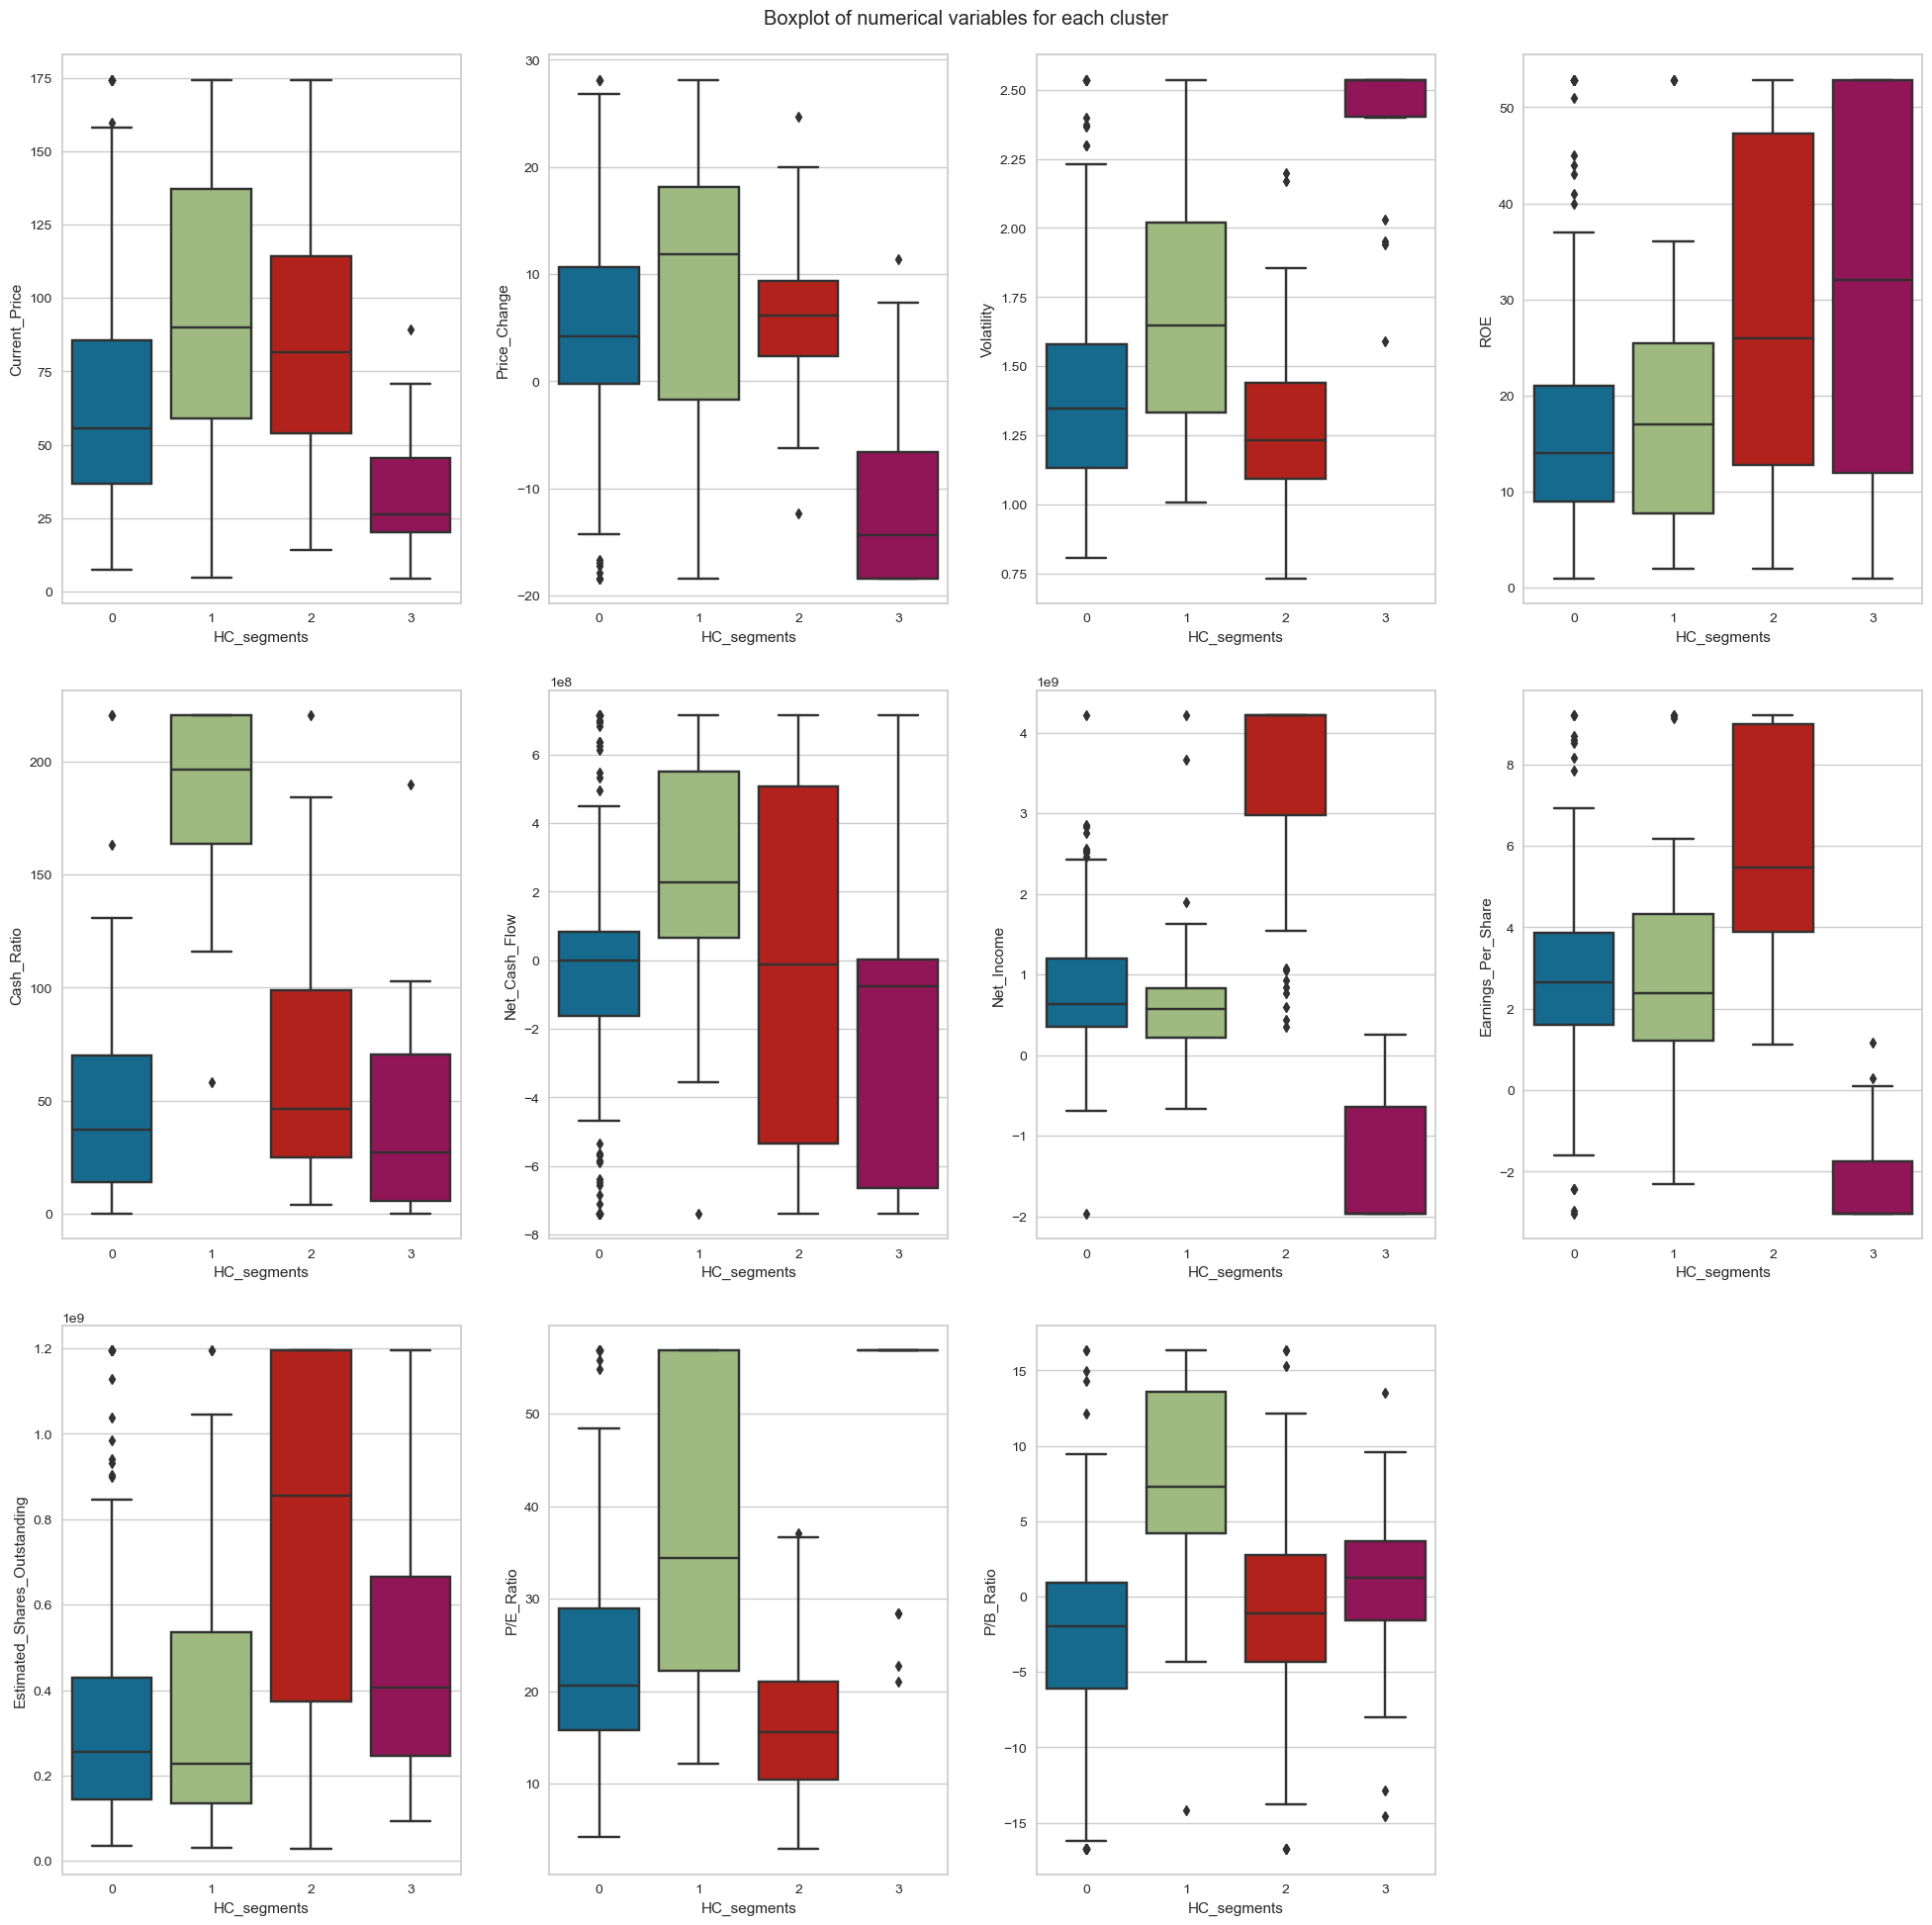

In [82]:
plt.figure(figsize=(20, 20))
plt.suptitle("Boxplot of numerical variables for each cluster")

for i, variable in enumerate(num_col):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data=df3, x="HC_segments", y=variable)

plt.tight_layout(pad=2.0)

### Insights from Hierarchical clustering

**Cluster 0**

* There are 217 companies mainly comprising Industrials, Financials, Consumer Discretionary, Real Estate sectors
* Stocks have moderate price, moderate price change%, medium volatility, moderate ROE, moderate cash ratio, low net cash flow, moderate net income, medium/high earnings per share, moderate estimated outstanding shares, moderate P/E ratio


**Cluster 1**

* There are 32 companies mainly comprising Information Technology, Healthcare sectors
* Stocks have high price, high price change %, medium/high volatility, moderate ROE, high cash ratio, high net_cash_flow, moderate net_income and earnings per share, moderate estimated outstanding shares, medium/high P/E ratio


**Cluster 2**

* There are 68 companies mainly comprising Industrials, Financials and Healthcare sectors
* Stocks have medium/high price, moderate price change%, low volatility, medium/high ROE, moderate cash ratio, low net_cash_flow, high net income, high earnings per share, high oustanding shares, high P/E ratio


**Cluster 3**

* There are 23 companies mainly comprising Energy sector
* Stocks have low price and low price change%, high volatility and ROE, low cash ratio and low cash flow, low net income and earnings per share, moderate oustanding shares and high P/E ratio


## K-means vs Hierarchical Clustering comparison


* K-means cluster 0 (162 companies): Consumer Discretionary,Industrials,Financials sectors
* K-means cluster 1 (67 companies): Healthcare and Consumer Discretionary
* K-means cluster 2 (73 companies): Financials, Industrials, Information Technology
* K-means cluster 3 (38 companies): Energy sector


* Hierarchical cluster 0 (217 companies): Industrials, Financials, Consumer Discretionary, Real Estate sectors
* Hierarchical cluster 1 (32 companies): Information Technology, Healthcare
* Hierarchical cluster 2 (68 companies): Industrials, Financials, Healthcare
* Hierarchical cluster 3 (23 companies): Energy


**How many clusters are obtained as the appropriate number of clusters from both algorithms?**
* Both algorithms yield 4 as appropriate number of clusters

**Which clustering technique gave more distinct clusters, or are they the same?**
* Both algorithms produced very similar results, K-means a tad bit more distinct in its 4 clusters than Hierachical 

**How many observations are in similar clusters of both algorithms?**
* Both algorithms have similar observations/cluster sizes - 1 big cluster(k means has 162 vs 217 Hierarchical), 2 smaller comparable sized clusters(k-means 67,73 vs 32,68 for Hierarchical) and 1 cluster with just 1 sector (k-means 38 vs Hierachical 23)
* Both methods have common sectors in all 4 clusters

**Which clustering technique took less time for execution?**
* Sklearn implementations of both algorithms have very small/similar execution times 
* Hierarchical clustering takes just slightly longer to run dendrograms


***Clusters from K-means algorithm will be used for final recommendations***


## Actionable Insights and Recommendations

* K-means algorithm clusters is chosen for final insights/recommendations
* 4 clusters obtained

**cluster 0

* There are 162 companies, mainly comprising Consumer Discretionary,Industrials,Financials sectors
* Stocks have moderate price and price change, medium volatility, low ROE, low cash ratio, low net cash flow, moderate net income, low/medium earnings per share, low estimated outstanding shares, moderate P/E ratio
* This cluster has a negative cash flow, low ROE and cash ratio, low earning per share and low outstanding shares indicate poor trading volume 
* This cluster is mainly comprised of Consumer discretionary and Industrials, these sectors could be a bit volatile
* These group of companies have shown moderate growth, so investors to be vigilant
* It might be helpful to analyze data from more quarters before making long term investment in this group

**cluster 1

* There are 67 companies mainly comprising Healthcare and Consumer Discretionary sectors
* Stocks have high price, high change in price, medium volatility, high ROE, high cash ratio, moderate net_cash_flow and net_income, high earnings per share, low estimated outstanding shares, moderate P/E ratio
* Among 4 clusters, this cluster has the highest stock price, highest price change, ROE, highest cash ratio, earnings per share
* It is worth mentioning, sometimes high P/E ratio of stocks could be indicative of overvaluation
* Overall, these companies have shown good growth in the previous quarter and could be ok to invest in

**cluster 2

* There are 73 companies mainly comprising Financials, Industrials and Information Technology  
* Stocks have moderate price, moderate price change, medium volatility, moderate ROE, medium cash ratio, high net_cash_flow, high net income, moderate earnings per share, high oustanding shares, low P/E ratio
* Among 4 clusters, this cluster has highest net cash flow, highest net income, highest outstanding shares
* These are good indicators that this is a safe group of companies to invest in

**cluster 3

* There are 23 companies comprising Energy sector
* Stocks are low priced, have dropped in price over the last 13 weeks, highly volatile, high ROE, moderate cash ratio, low net cashflow, low net income, low earnings per share, moderate estimated outstanding shares, high P/E ratio
* Among 4 clusters, this cluster has the highest volatility, ROE and P/E ratio
* This indicates companies from this sector have performed poorly in the previous quarter
* This is a group that has not shown good growth in the previous quarter
* Investors to be cautious while picking companies in this cluster as most indicators are not positive

**Other:

* Trade&Ahead can do a deep dive, perform cluster analysis on individual sectors for better insights on stock performance and risk tolerance
* Trade&Ahead can perform YOY (year over year) analysis to understand/predict stock trend over longer periods of time
